# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import probplot

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier

from imblearn.combine import SMOTEENN

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
plt.style.use('fivethirtyeight')
sns.set_context('paper',
                rc = {'font.size' : 13,
                      'axes.titlesize' : 11,
                      'axes.labelsize' : 9})
pd.options.display.max_columns = 100

# Loading Data

In [3]:
# Reading CSV files to pandas and fills nan/missing values as numpy.nan

actual_trainDF = pd.read_csv('../data/raw/train.csv', na_values = np.nan).drop_duplicates()
actual_testDF = pd.read_csv('../data/raw/test.csv', na_values = np.nan).drop_duplicates()
submissionDF = pd.read_csv('../data/raw/sample_submission.csv', na_values = np.nan).drop_duplicates()

# Data Sanity Check

In [4]:
print(f'Shape of actual Train Dataset : {actual_trainDF.shape}\n')
actual_trainDF.head(3)

Shape of actual Train Dataset : (39211, 16)



,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no


In [5]:
print(f'Shape of actual Test Dataset : {actual_testDF.shape}\n')
actual_testDF.head(3)

Shape of actual Test Dataset : (10000, 15)



,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN


In [6]:
# Check for train datasets Datatypes

actual_trainDF.info()
actual_trainDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
# Check for test datasets Datatypes

actual_testDF.info()
actual_testDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  10000 non-null  object
 1   age                10000 non-null  int64 
 2   job                9941 non-null   object
 3   marital            10000 non-null  object
 4   education          9610 non-null   object
 5   default            10000 non-null  object
 6   balance            10000 non-null  int64 
 7   housing            10000 non-null  object
 8   loan               10000 non-null  object
 9   contact            7316 non-null   object
 10  duration           10000 non-null  int64 
 11  campaign           10000 non-null  int64 
 12  pdays              10000 non-null  int64 
 13  previous           10000 non-null  int64 
 14  poutcome           2492 non-null   object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


,age,balance,duration,campaign,pdays,previous
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,42.261200,5328.789200,437.117700,5.159700,71.705700,12.028100
std,12.650137,15944.545194,761.232963,9.975928,160.374253,44.467155
min,18.000000,-3372.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,92.000000,108.000000,1.000000,-1.000000,0.000000
50%,40.000000,541.000000,196.000000,2.000000,-1.000000,0.000000
75%,50.000000,2051.000000,380.000000,4.000000,-1.000000,0.000000
max,94.000000,101418.000000,4909.000000,63.000000,871.000000,275.000000


In [8]:
# for Kaggle instead of legend = False, might have to use dodge = False and
# ax.legend_.remove() need to be added before plt.show().
# This is beacuse of the chnage in versions of Seaborn

def plot_target(df: pd.DataFrame, title_text: str) -> None:
    '''
    Plots the count of the target variable in the given dataframe.
    '''
    fig = plt.figure(figsize = (6, 7))
    ax = sns.countplot(data = df, x = 'target', hue = 'target', palette = 'flare', orient = 'v', legend = False)
    plt.title(f'Target variable count on {title_text}')
    for p in ax.patches:
        ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center',
                    va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 9)
    ax.set_xlabel('Target'); ax.set_ylabel('')
    plt.show()

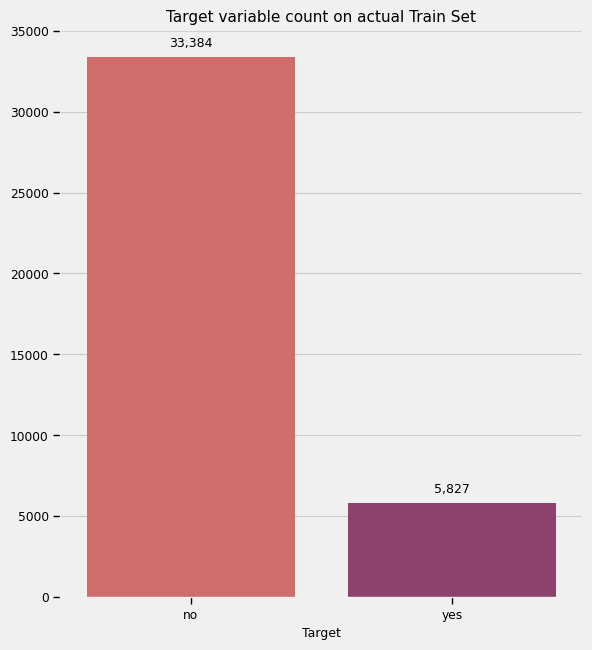

In [9]:
plot_target(actual_trainDF, 'actual Train Set')

In [10]:
# Converting date feature columns to pandas datetime format

actual_trainDF['last contact date'] = pd.to_datetime(actual_trainDF['last contact date'])
actual_testDF['last contact date'] = pd.to_datetime(actual_testDF['last contact date'])

In [11]:
p_string = 'Number of unique features in Training Data'
print(p_string); print('-' * len(p_string))
actual_trainDF.nunique()

Number of unique features in Training Data
------------------------------------------


last contact date    1013
age                    78
job                    11
marital                 3
education               3
default                 2
balance              9535
housing                 2
loan                    2
contact                 2
duration             3146
campaign               63
pdays                 865
previous              276
poutcome                3
target                  2
dtype: int64

In [12]:
p_string = 'Number of unique features in actual Testing Data'
print(p_string); print('-' * len(p_string))
actual_testDF.nunique()

Number of unique features in actual Testing Data
------------------------------------------------


last contact date     908
age                    77
job                    11
marital                 3
education               3
default                 2
balance              4384
housing                 2
loan                    2
contact                 2
duration             1664
campaign               63
pdays                 679
previous              261
poutcome                3
dtype: int64

### Checking for Missing Value features 

In [13]:
# Checking missing values on the train dataset

missing_train = pd.DataFrame(actual_trainDF.isnull().sum()).reset_index(drop = False)
missing_train.columns = ['Features', 'Missing_Count']
missing_train['Missing_Percent'] = round(missing_train.Missing_Count *100 / actual_trainDF.shape[0], 2)
missing_train.query('Missing_Percent > 0').reset_index(drop = True)

,Features,Missing_Count,Missing_Percent
0,job,229,0.58
1,education,1467,3.74
2,contact,10336,26.36
3,poutcome,29451,75.11


In [14]:
# Checking missing values on the test dataset

missing_test = pd.DataFrame(actual_testDF.isnull().sum()).reset_index(drop = False)
missing_test.columns = ['Features', 'Missing_Count']
missing_test['Missing_Percent'] = missing_test.Missing_Count *100 / actual_testDF.shape[0]
missing_test.query('Missing_Percent > 0').reset_index(drop = True)

,Features,Missing_Count,Missing_Percent
0,job,59,0.59
1,education,390,3.90
2,contact,2684,26.84
3,poutcome,7508,75.08


**Observation**
- Missing values are present in both train and test datasets.
- The null values are present in the following columns : 'job', 'education', 'contact', 'poutcome'.
- This missing percent on each features are almost same for both train and test sets.
- Since the target data is not equaly distributed, we can use *stratified fashion* data split for training and testing purposes.

# Exploratory Data Analysis

In [15]:
# Mapping binary categorical features to numericals : default, housing, loan, target

for col in ['default', 'housing', 'loan', 'target']:
    try:
        actual_trainDF[col] = actual_trainDF[col].replace({'no' : '0', 'yes' : '1'}).astype(int)
        actual_testDF[col] = actual_testDF[col].replace({'no' : '0', 'yes' : '1'}).astype(int)
    except: pass

## Categorical features

In [16]:
def plotCategoricalPlot(df: pd.DataFrame, on_feature: list[str], title_text: str) -> None:
    '''
    Plots the distribution of categorical features against the target variable.
    '''
    fig = plt.figure(figsize = (18,  3 * 5))
    gs = GridSpec(3, 3)

    if title_text == 'Testing Data': df = df.drop('target', axis = 1).copy(deep  =True)
        
    tar_present = 'target' in df.columns
    
    for idx, col in enumerate(on_feature):

        if tar_present: hue = 'target'
        else: hue = col
            
        if (idx %3 == 2) and tar_present: legend = True
        else: legend = False
            
        if idx+1 == len(on_feature):
            if 'target' in df.columns: legend = True
                
            ax = plt.subplot(gs[idx // 3, idx % 3:])
            img = sns.countplot(data = df.fillna('NaN'), x = 'job', hue = hue, palette = 'Paired', orient = 'v',
                                ax = ax, legend = legend)
        else:
            ax = plt.subplot(gs[idx // 3, idx % 3])
            img = sns.countplot(data = df.fillna('NaN'), x = col, hue = hue, palette = 'Paired', orient = 'v',
                                ax = ax, legend = legend)
        for p in img.patches:
            if p.get_height() > 0: # annotates only if the height is > 0
                ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 9)

        if tar_present: ax.set_title(f'{col} vs target')
        else: ax.set_title(col)
        ax.set_xlabel('')
        
    fig.suptitle(f'Categorical features on {title_text} Set')
    plt.tight_layout(pad = 2.5)
    plt.show()

In [17]:
# Categorical features : actual Training Data

p_string = 'Categorical features and its unique values in actual Training Data'
print(p_string); print('-' * len(p_string))

train_discreate_features = actual_trainDF.select_dtypes(exclude = [int, float, np.datetime64]).columns
for col in train_discreate_features:
    if col == 'last contact date':
        continue
    print(f'{col:15} : {list(actual_trainDF[col].unique())}')

Categorical features and its unique values in actual Training Data
------------------------------------------------------------------
job             : ['blue-collar', 'technician', 'admin.', 'entrepreneur', 'unemployed', 'management', 'services', 'student', 'self-employed', 'retired', 'housemaid', nan]
marital         : ['married', 'single', 'divorced']
education       : ['secondary', 'tertiary', 'primary', nan]
contact         : ['cellular', 'telephone', nan]
poutcome        : ['other', nan, 'failure', 'success']


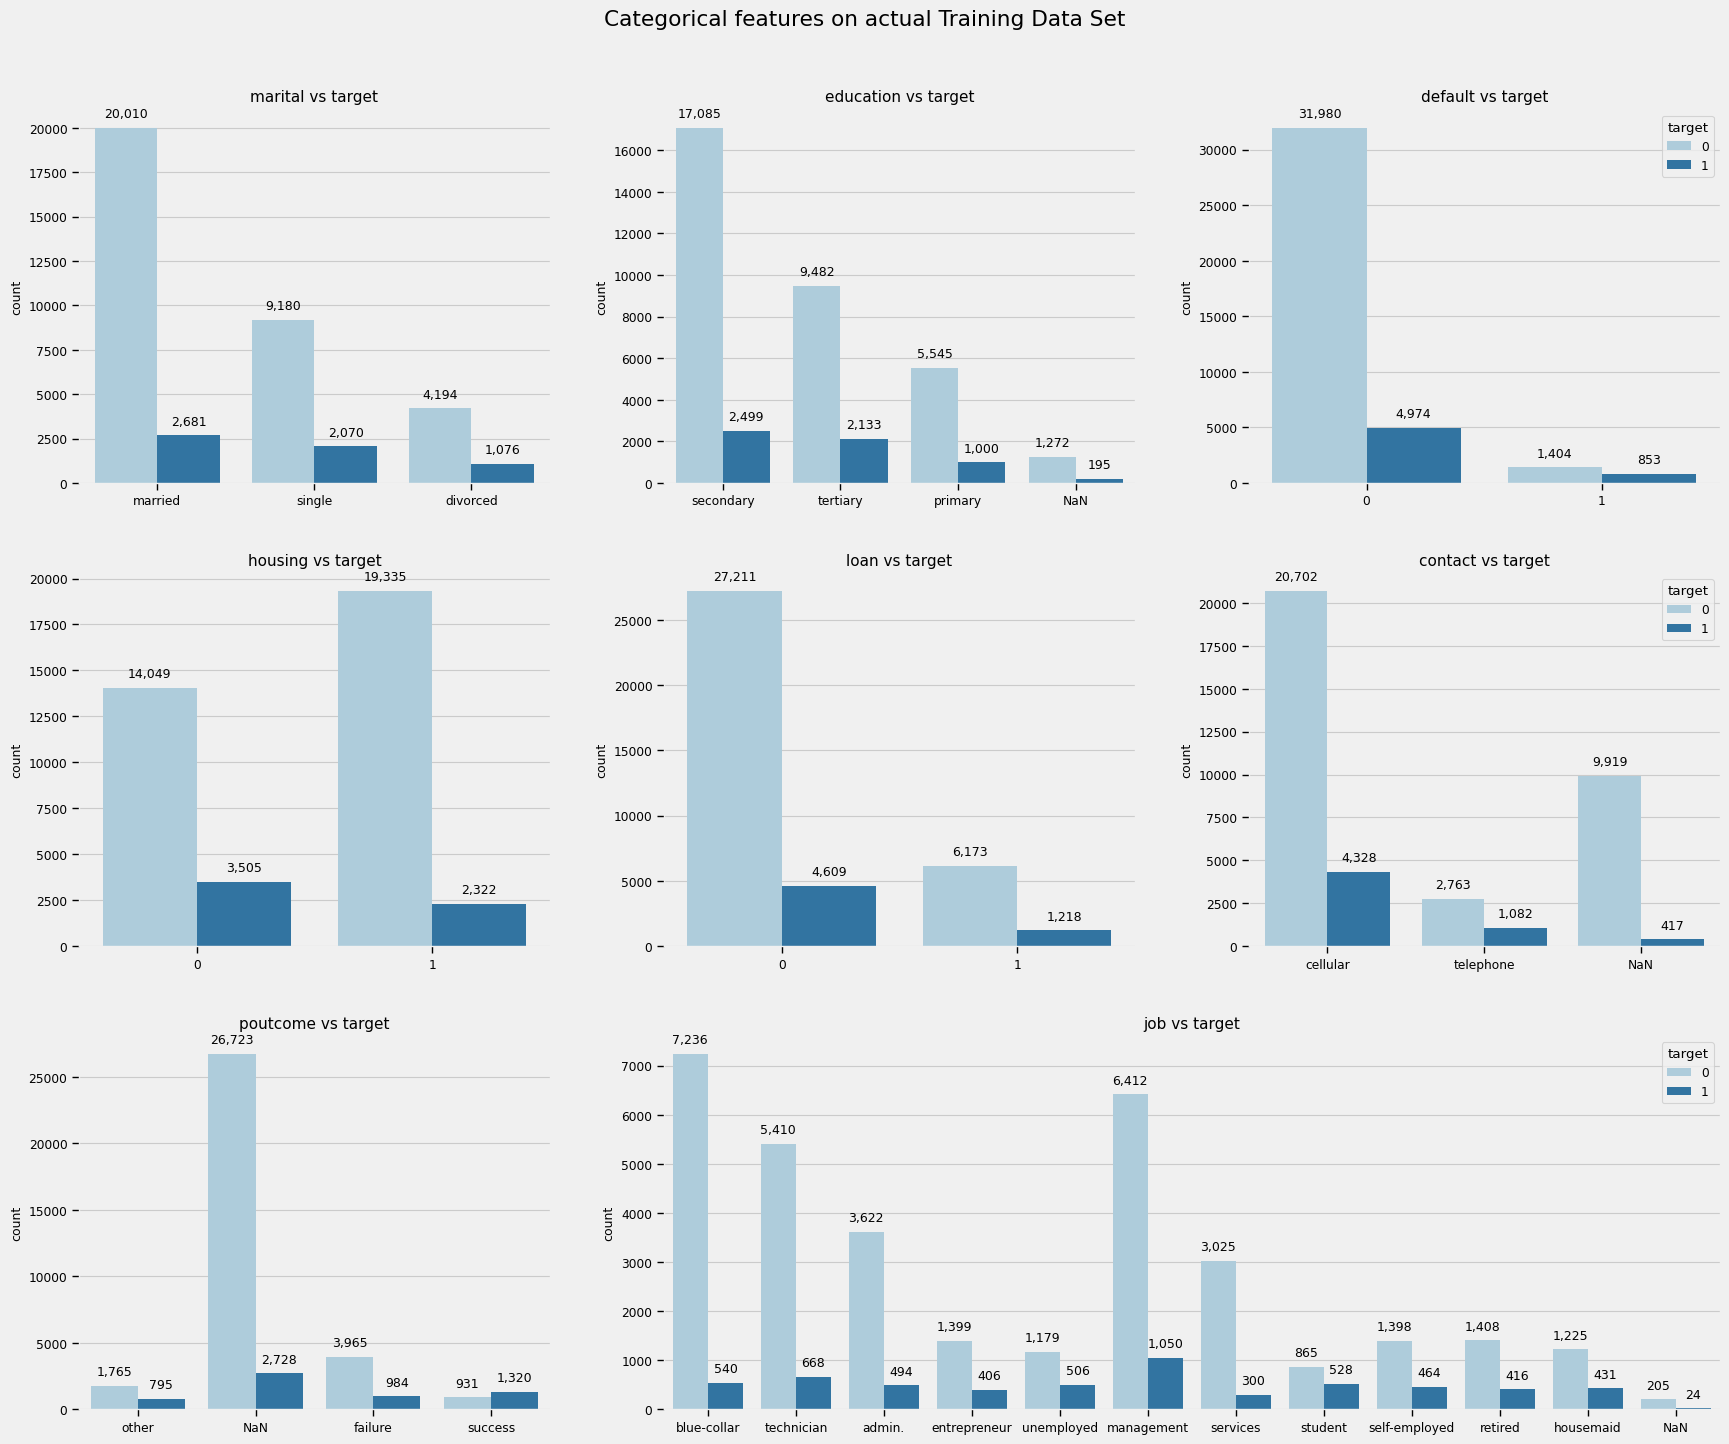

In [18]:
plotCategoricalPlot(actual_trainDF, ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'job'],
                    'actual Training Data')

In [19]:
# Categorical features : Testing Data

p_string = 'Categorical features and its unique values in actual Testing Data'
print(p_string); print('-' * len(p_string))

test_discreate_features = actual_testDF.select_dtypes(exclude = [int, float, np.datetime64]).columns
for col in test_discreate_features:
    if col == 'last contact date':
        continue
    print(f'{col:15} : {list(actual_testDF[col].unique())}')

Categorical features and its unique values in actual Testing Data
-----------------------------------------------------------------
job             : ['management', 'unemployed', 'blue-collar', 'admin.', 'services', 'student', 'technician', nan, 'self-employed', 'retired', 'housemaid', 'entrepreneur']
marital         : ['single', 'married', 'divorced']
education       : ['tertiary', 'secondary', 'primary', nan]
contact         : [nan, 'cellular', 'telephone']
poutcome        : [nan, 'failure', 'other', 'success']


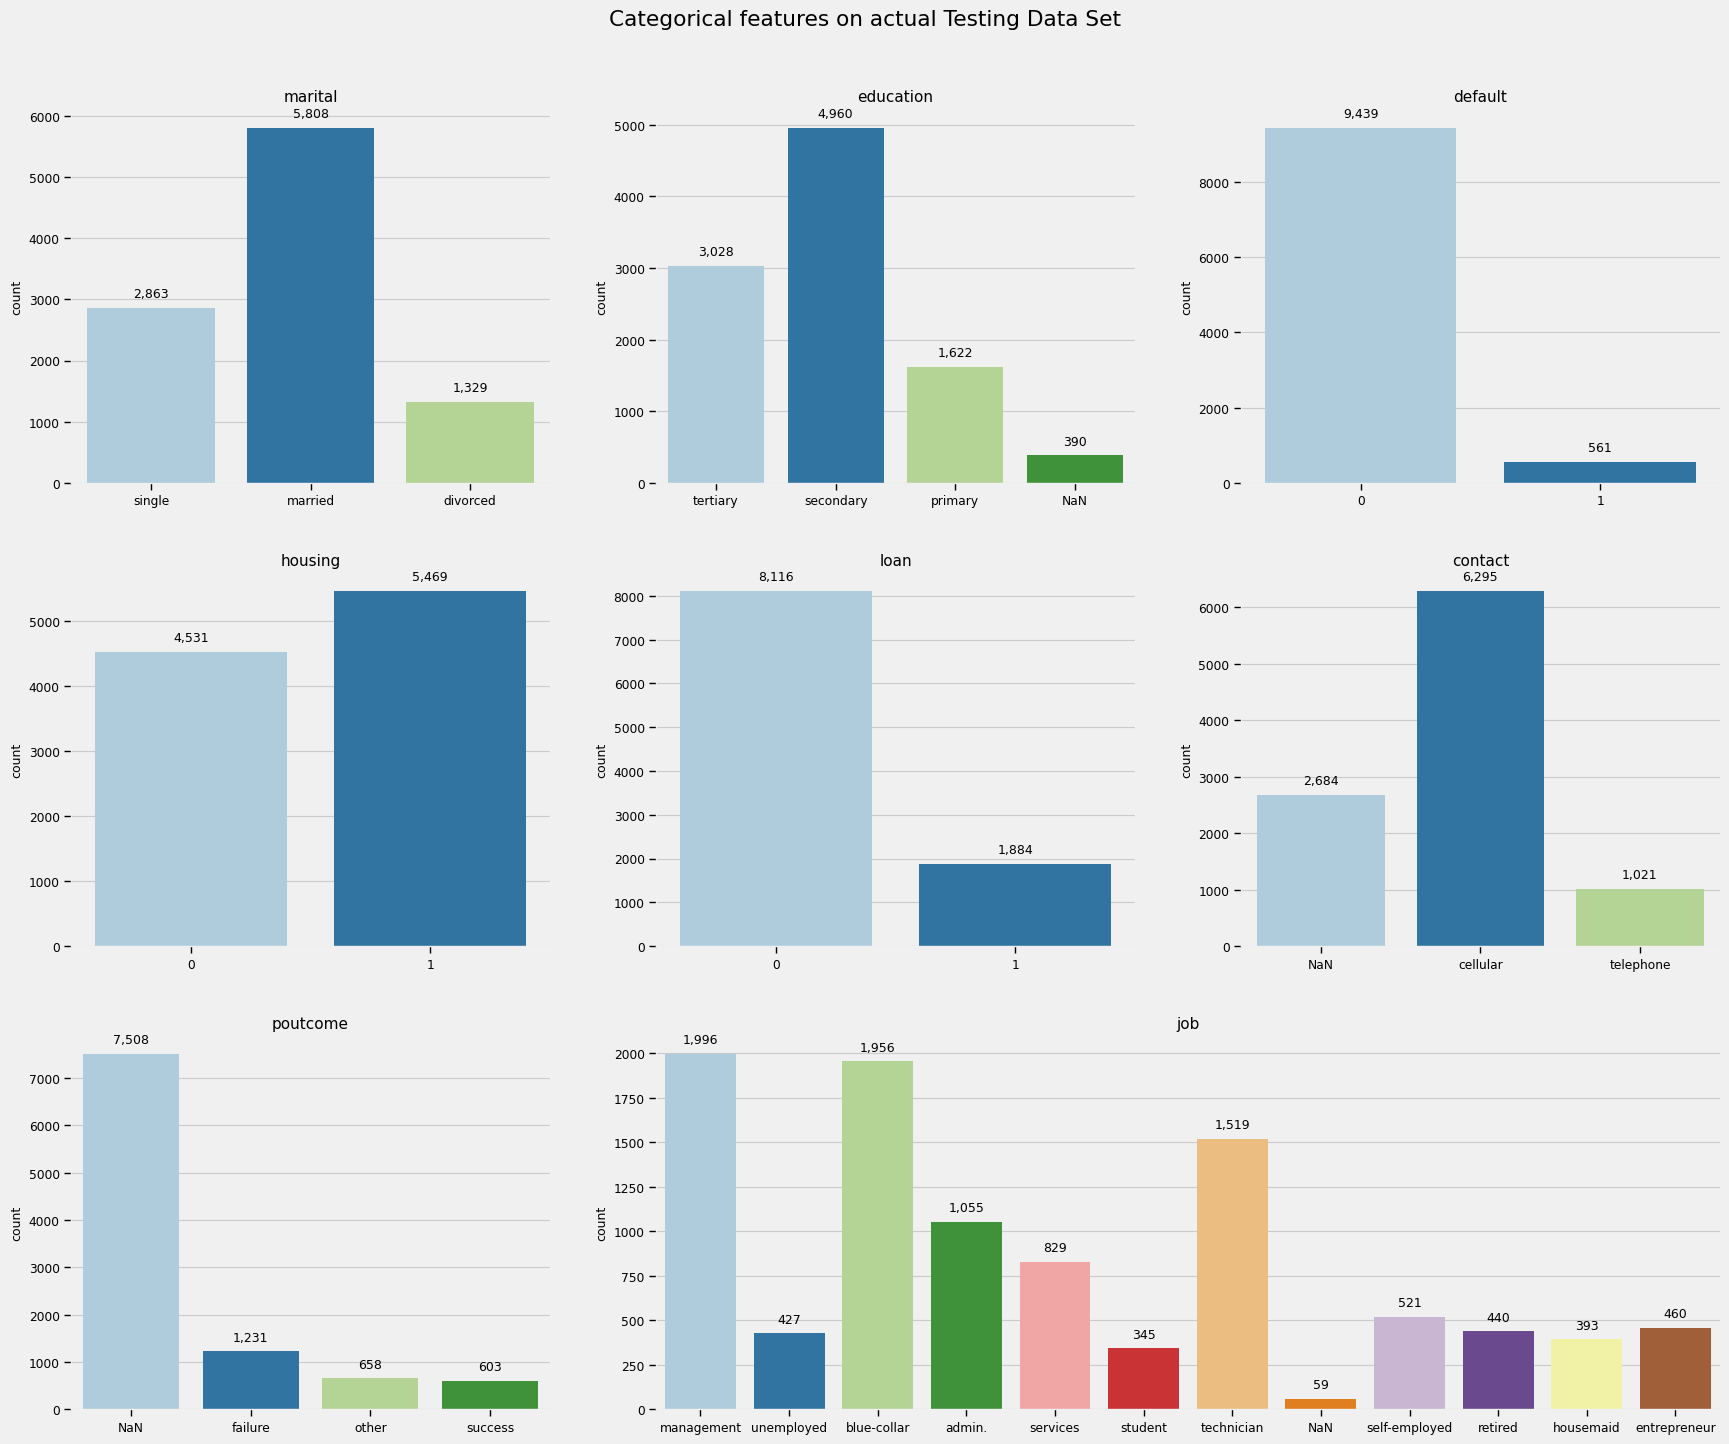

In [20]:
plotCategoricalPlot(actual_testDF, ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'job'],
                    'actual Testing Data')

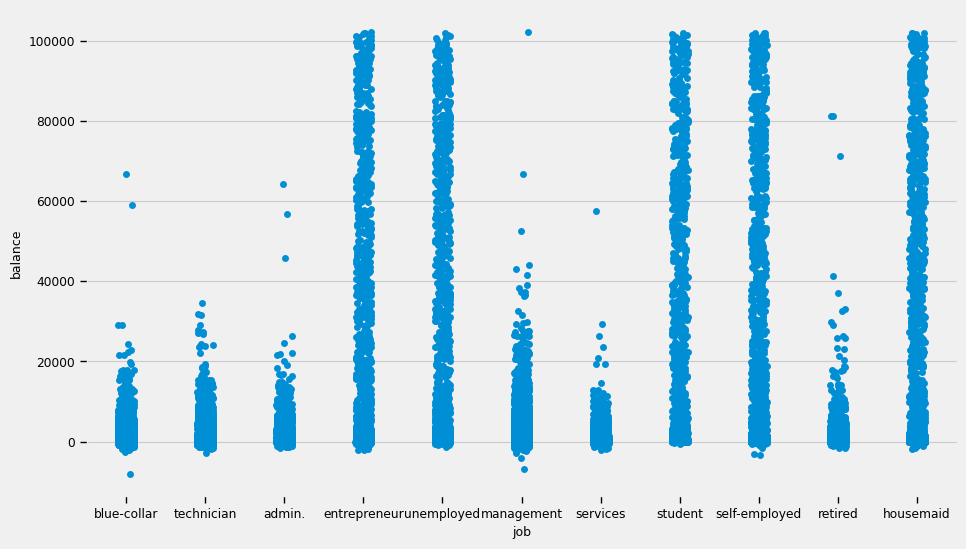

In [21]:
fig = plt.figure(figsize = (10, 6))
sns.stripplot(data = actual_trainDF, x = 'job', y = 'balance')
plt.show()

## Continuous features

In [22]:
def plot_continuous_param(df: pd.DataFrame, param: str, kde_alone: bool = False, mean_mode: bool = False,
                          box_not_violin: bool = True) -> None:
    '''
    Plots continuous feature distributions with options for KDE, mean, mode, and box/violin plots.
    '''

    if 'target' not in df.columns:
        raise("Function only accepts train dataset with 'y' label")
        
    fig = plt.figure(figsize = (3 * 5.5, 6))
    gs = GridSpec(1, 3)
    
    mean_, mode_= df[param].mean(), df[param].mode().values

    # Plot 1
    ax = plt.subplot(gs[0 // 3, 0 % 3])
    if kde_alone:
        sns.kdeplot(data = df, x = param, color = 'indianred', ax = ax)
    else:
        sns.histplot(data = df, x = param, kde = True, color = 'indianred', ax = ax,
                     label = f'Skewness : {round(df[param].skew(), 3)}')
        plt.legend([f'Skewness: {round(df[param].skew(), 3)}'], handlelength = 0, handletextpad = 0,
                   loc = 'upper right')
    ax.set_xlabel('')
    
    # Plot 2
    if mean_mode:
        plt.axvline(mean_, color = '#00C5FF')
        plt.text(x = mean_ * 1.1, y = plt.ylim()[1] * 0.92, horizontalalignment = 'left',
                 s = 'Mean', rotation = 90, fontsize = 9)
        plt.axvline(mode_, color = '#06DF3F')
        plt.text(x = mode_ * 0.9, y = plt.ylim()[1] * 0.92, horizontalalignment = 'right',
                 s = 'Mode', rotation = 90, fontsize = 9)
        
    ax = plt.subplot(gs[1 // 3, 1 % 3])
    if box_not_violin:
        sns.boxplot(data = df, x = 'target', y = param, hue = 'target', palette = 'Paired', ax = ax)
    else:
        sns.violinplot(data = df, x = 'target', y = param, hue = 'target', palette = 'Paired', ax = ax)
    ax.set_xlabel('')

    # Plot 3
    # https://www.kaggle.com/code/ysthehurricane/methods-of-normality-tests-in-statistics
    
    ax = plt.subplot(gs[2 // 3, 2 % 3])
    _, pvalue = kstest(df[param], 'norm')
    normal_or_not = 'Normally Distributed' if pvalue > 0.05 else 'Not Normally Distributed'
    probplot(df[param], dist = 'norm', plot = plt)
    ax.set_title(f'Q-Q Plot : {normal_or_not}')
    ax.set_ylabel('')
    
    fig.suptitle(f'{param.title()} :: Train Dataset')
    plt.tight_layout(pad = 1.5)
    plt.show()

In [23]:
def plot_transformed_features(df: pd.DataFrame, param: str) -> None:
    '''
    Plots transformations (log, square root, cube root, etc.) of a continuous feature.
    '''
    onSet = 'Train' if 'target' in df.columns else 'Test'
        
    tempDF = df[[param]].copy(deep = True)
    
    try: tempDF['Log'] = tempDF[param].apply(lambda value : np.log(value) if value > 0 else 0)
    except: pass
    try: tempDF['SquareRoot'] = tempDF[param].apply(lambda value : np.sqrt(value) if value > 0 else 0)
    except: pass
    try: tempDF['CubeRoot'] = np.cbrt(tempDF[param])
    except: pass
    try: tempDF['BoxCox'], _ = boxcox(tempDF[param])
    except: pass
    try: tempDF['YeoJohnson'], _ = yeojohnson(tempDF[param])
    except: pass
        
    original_ = tempDF.columns[0]
    tempDF.rename(columns = {tempDF.columns[0]: 'Original'}, inplace = True)
    
    fig = plt.figure(figsize = (tempDF.shape[1] * 5.5, 7))
    gs = GridSpec(1, tempDF.shape[1])

    ks_testDF = pd.DataFrame(columns = [original_, 'KS Statistic', 'P-Value'])
    
    for idx, col in enumerate(tempDF.columns):
        ax = plt.subplot(gs[0, idx])
        sns.histplot(data = tempDF, x = col, kde = True, color = 'indianred', ax = ax)
        plt.legend([f'Skewness: {round(tempDF[col].skew(), 3)}'], handlelength = 0, handletextpad = 0,
                    loc = 'upper right')

        standardized_data = (tempDF[col] - tempDF[col].mean()) / tempDF[col].std()
        ksStat, pvalue = kstest(standardized_data, 'norm')
        # ksStat, pvalue = kstest(tempDF[col], 'norm')
        normal_or_not = 'Normally Distributed' if pvalue > 0.05 else 'Not Normally Distributed'
        ks_testDF.loc[len(ks_testDF)] = [col, ksStat, pvalue]
        
        ax.set_title(col)
        ax.set_xlabel('')
        
    fig.suptitle(f'{original_.title()} : on {onSet} set')
    plt.tight_layout(pad = 1.5)
    plt.show()
    
    # return ks_testDF.round(5)

In [24]:
# Continuous features : actual Training Data

p_string = 'Continuous features and number of unique values in actual Training Data'
print(p_string); print('-' * len(p_string))

train_continuous_features = actual_trainDF.select_dtypes(include = [int, float, np.datetime64]).columns
for col in train_continuous_features:
    no_unique = actual_trainDF[col].nunique()
    if no_unique < 3: continue
    print(f'{col:18} : {no_unique}')

Continuous features and number of unique values in actual Training Data
-----------------------------------------------------------------------
last contact date  : 1013
age                : 78
balance            : 9535
duration           : 3146
campaign           : 63
pdays              : 865
previous           : 276


In [25]:
# Continuous features : actual Training Data

p_string = 'Continuous features and number of unique values in actual Testing Data'
print(p_string); print('-' * len(p_string))

test_continuous_features = actual_testDF.select_dtypes(include = [int, float, np.datetime64]).columns
for col in test_continuous_features:
    no_unique = actual_testDF[col].nunique()
    if no_unique < 3: continue
    print(f'{col:18} : {no_unique}')

Continuous features and number of unique values in actual Testing Data
----------------------------------------------------------------------
last contact date  : 908
age                : 77
balance            : 4384
duration           : 1664
campaign           : 63
pdays              : 679
previous           : 261


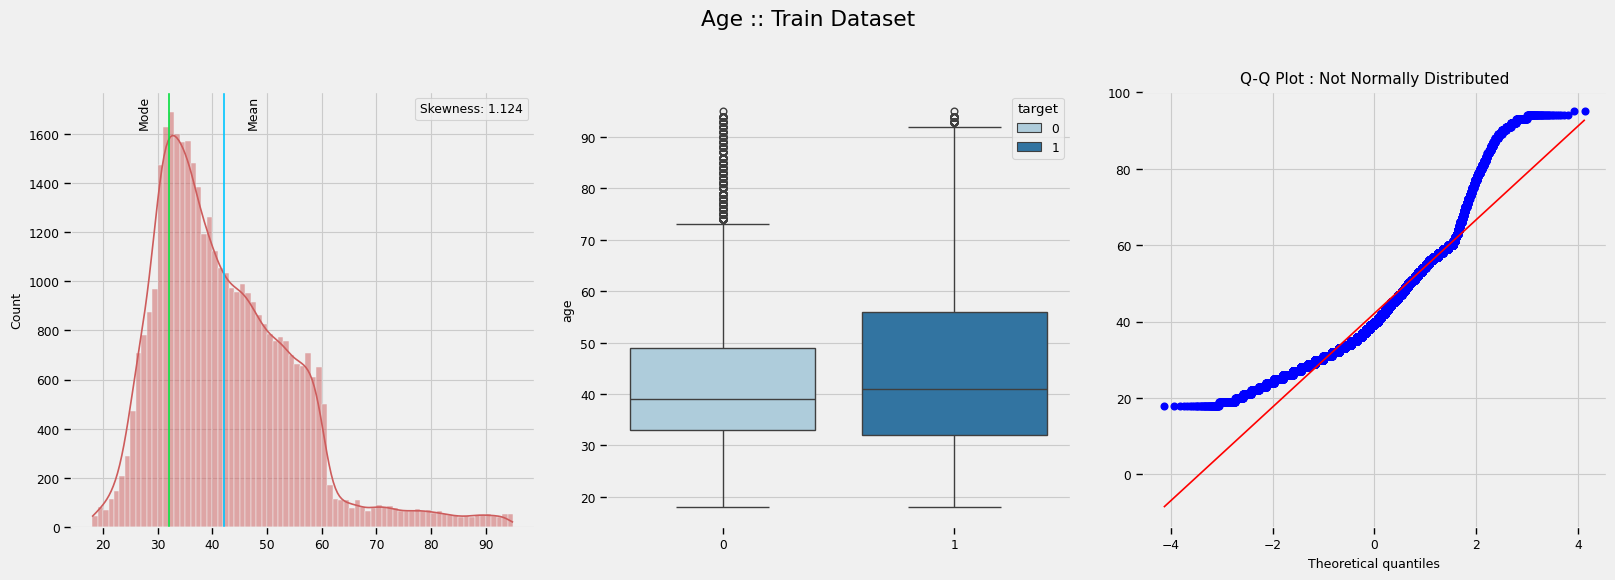

In [26]:
plot_continuous_param(actual_trainDF, 'age', kde_alone = False, mean_mode = True, box_not_violin = True)

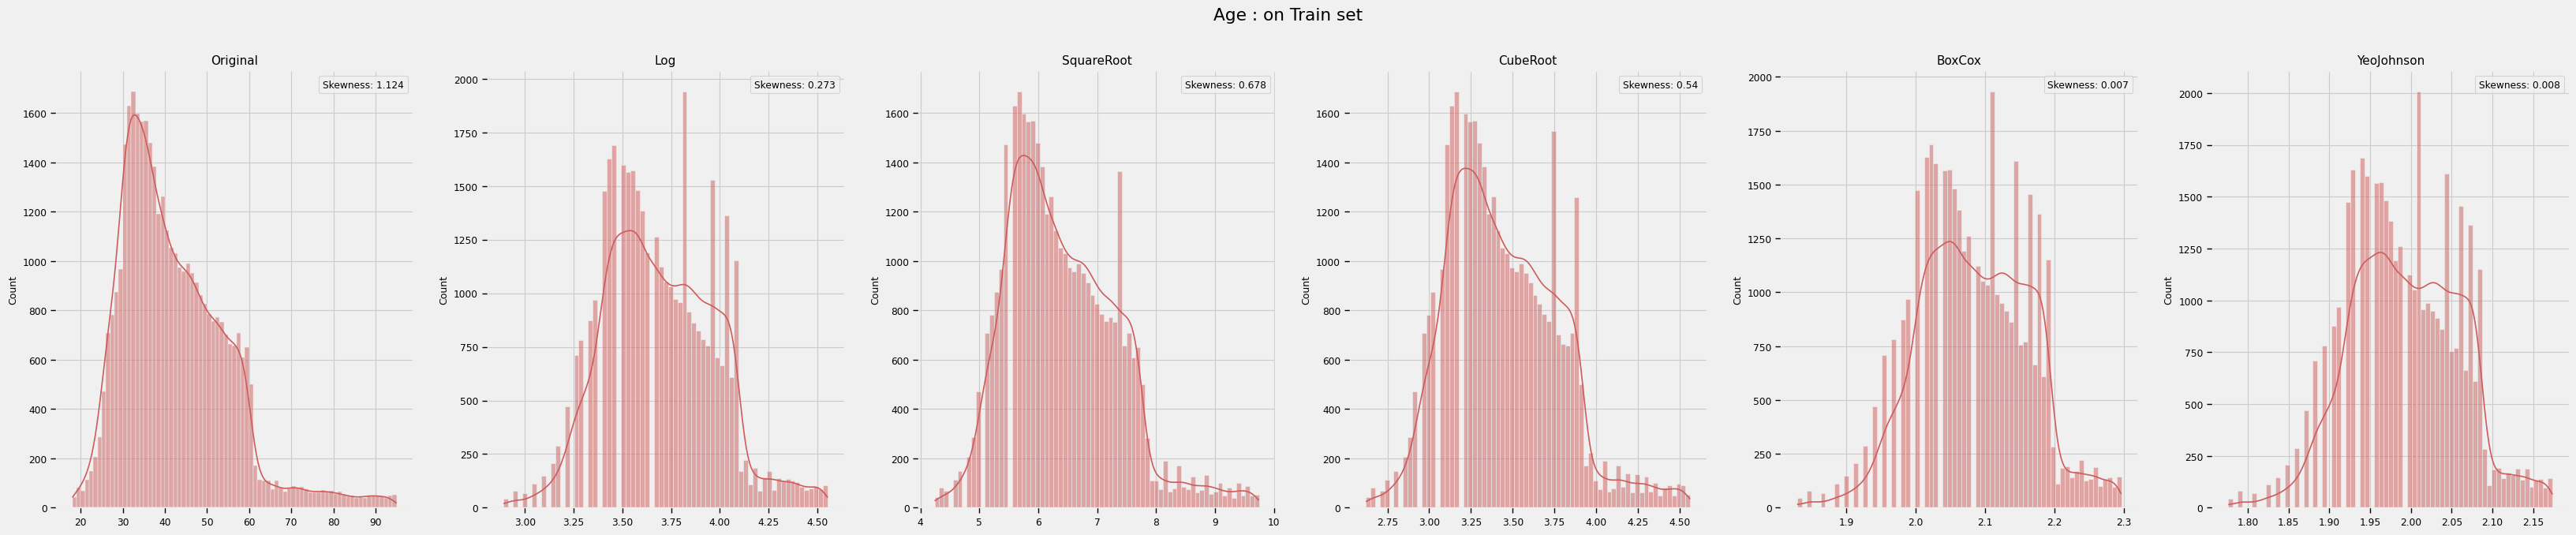

In [27]:
plot_transformed_features(actual_trainDF, 'age')

- As we see in the above distribution, most of the customers are in the age range of 30-40.
- From the above boxplot we know that for both the customers that subscibed or didn't subscribe a term deposit, has a median age of around 38-40. And the boxplot for both the classes overlap quite a lot, which means that age isn't necessarily a good indicator for which customer will subscribe and which customer will not.

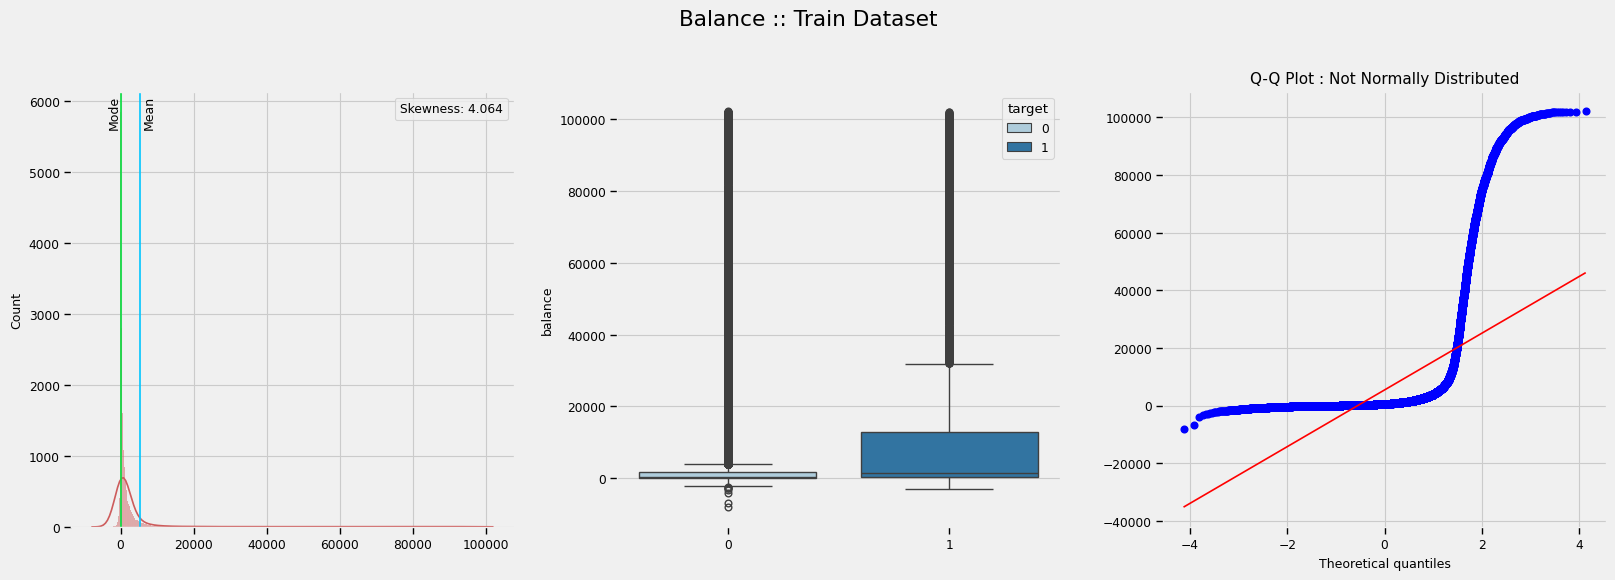

In [28]:
plot_continuous_param(actual_trainDF, 'balance', kde_alone = False, mean_mode = True, box_not_violin = True)

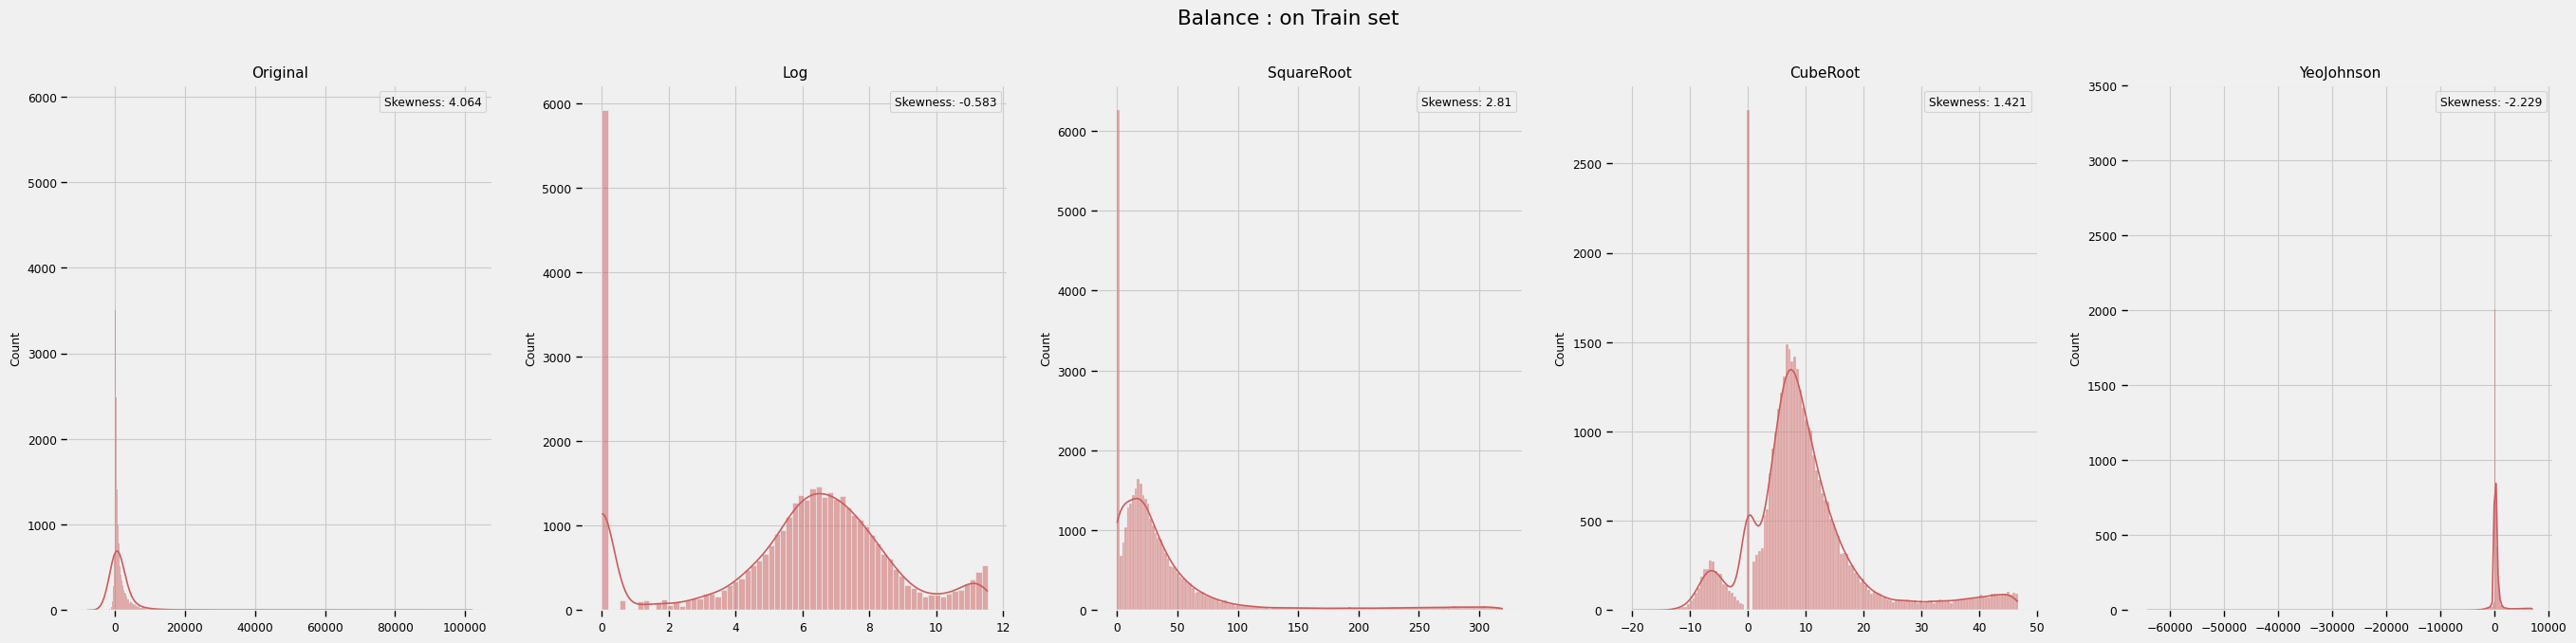

In [29]:
plot_transformed_features(actual_trainDF, 'balance')

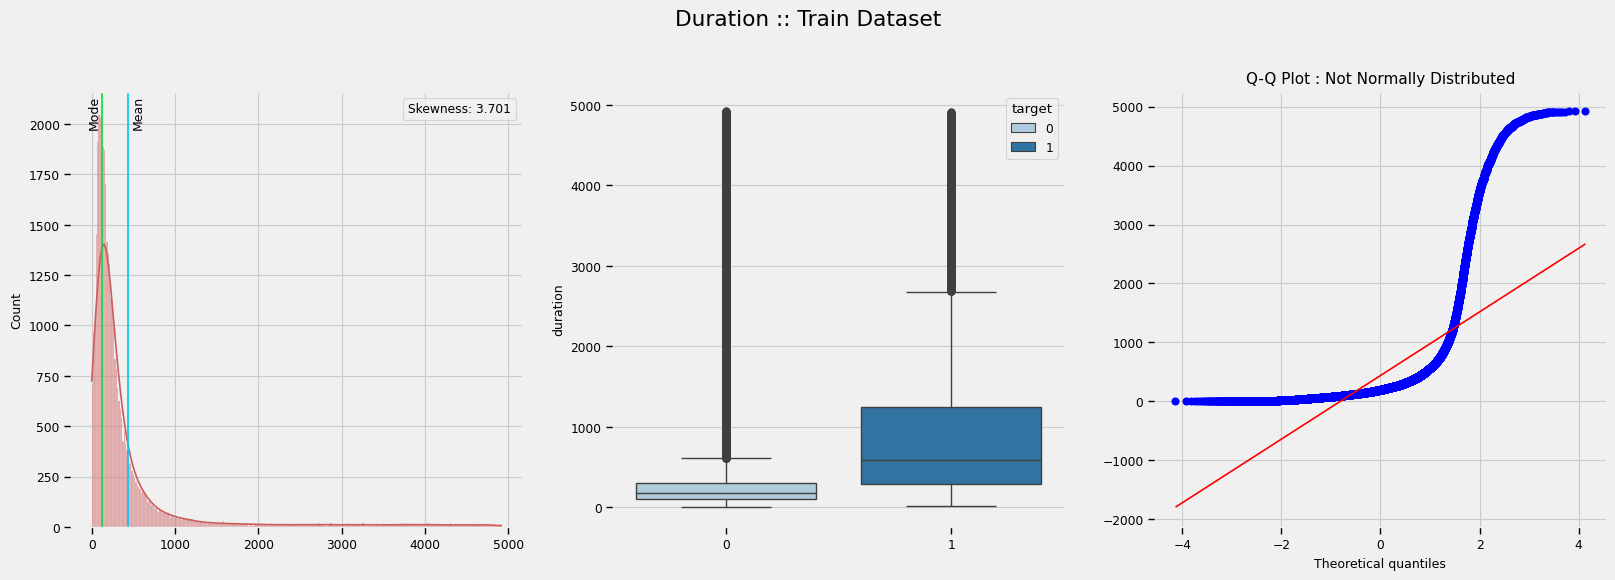

In [30]:
plot_continuous_param(actual_trainDF, 'duration', kde_alone = False, mean_mode = True, box_not_violin = True)

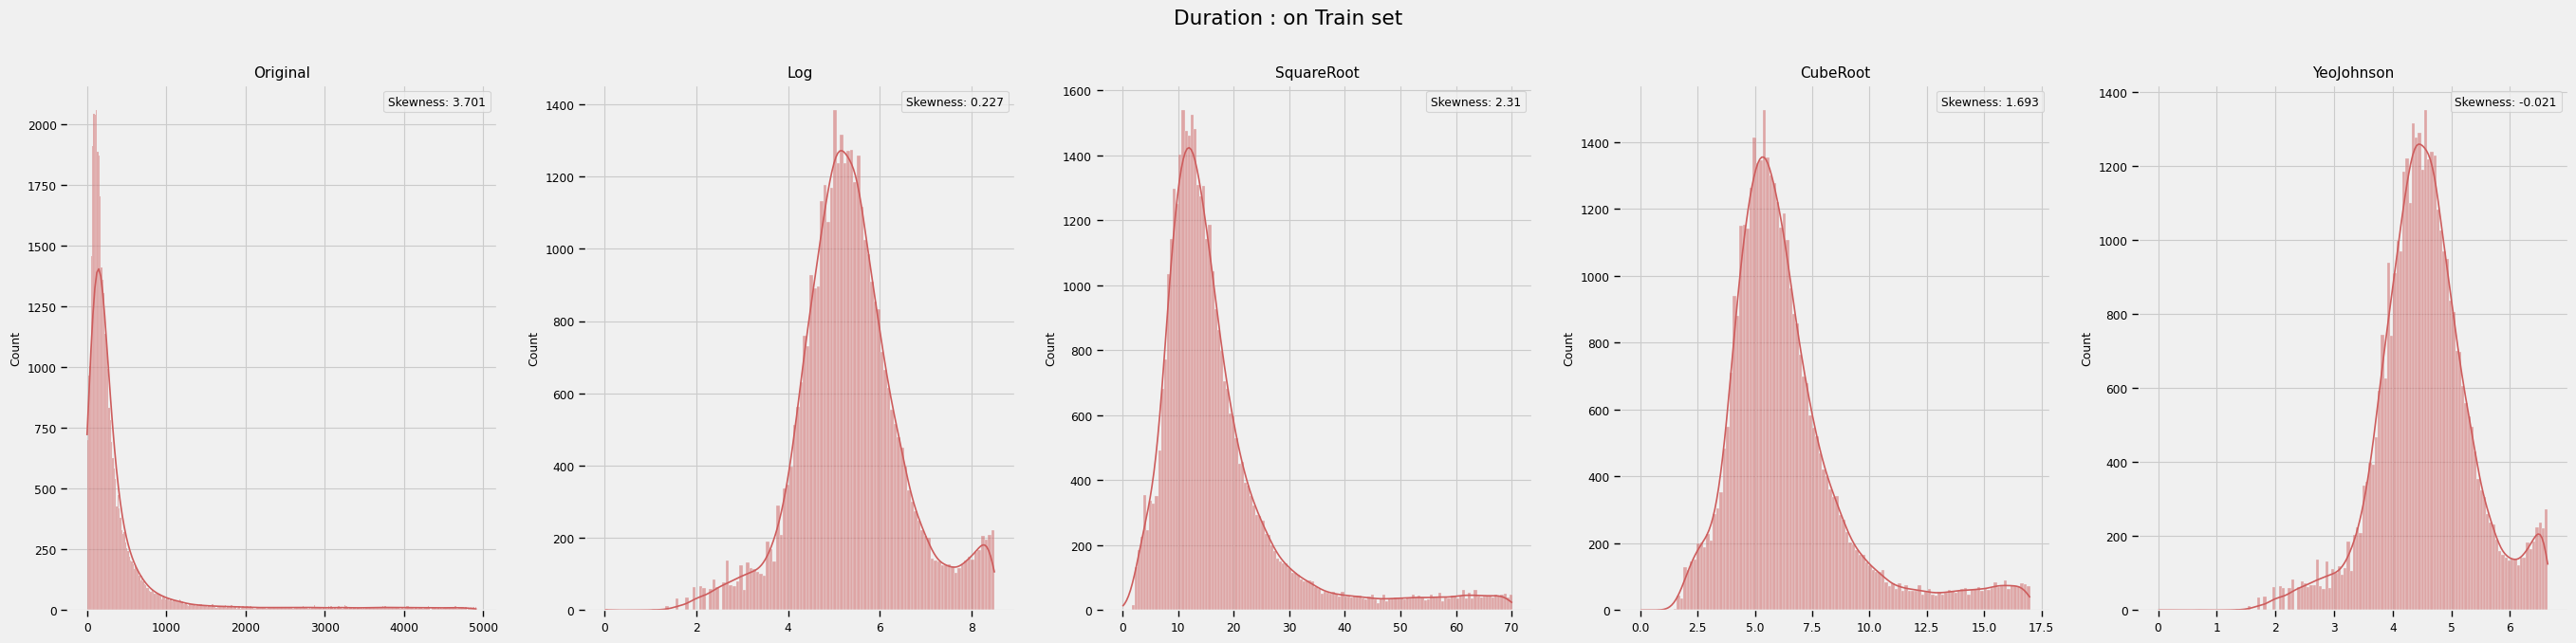

In [31]:
plot_transformed_features(actual_trainDF, 'duration')

- This seems like a powerlaw distribution where most the values are very low and high values are very few.
- The `log` transformation brings the distribution to alomost normal distribution with a slightly low skewness.

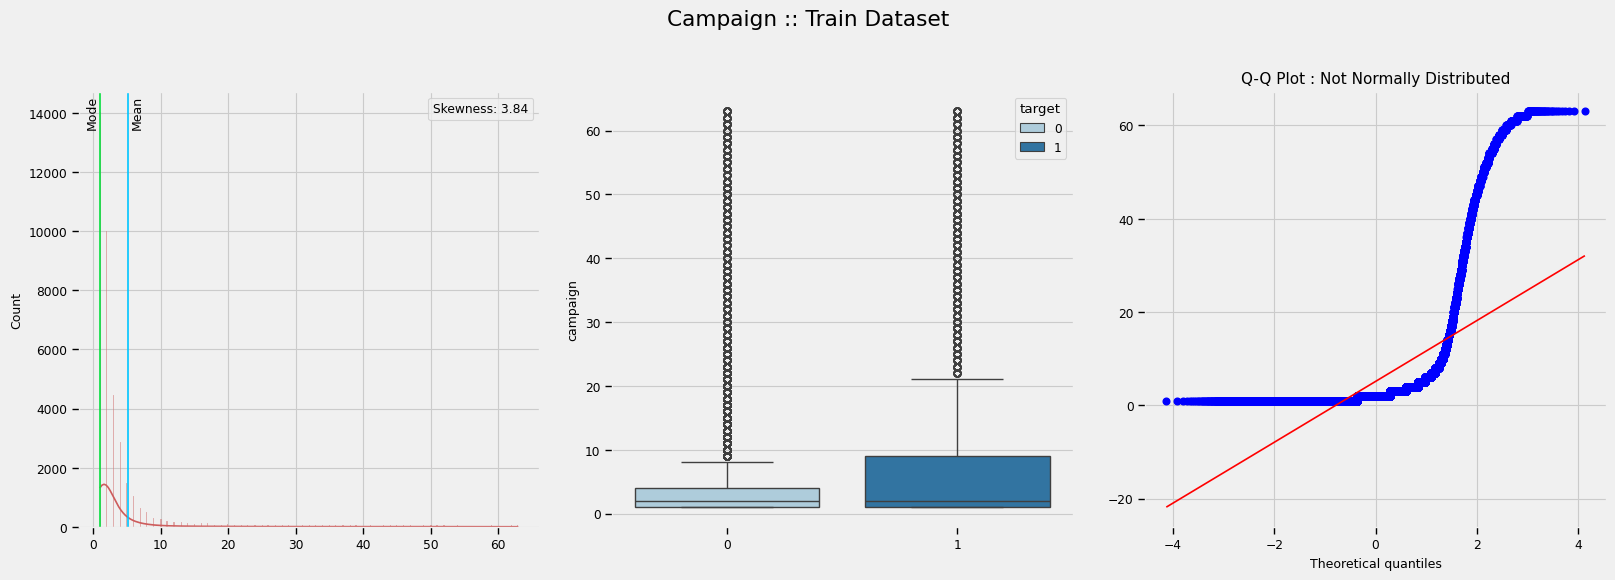

In [32]:
plot_continuous_param(actual_trainDF, 'campaign', kde_alone = False, mean_mode = True, box_not_violin = True)

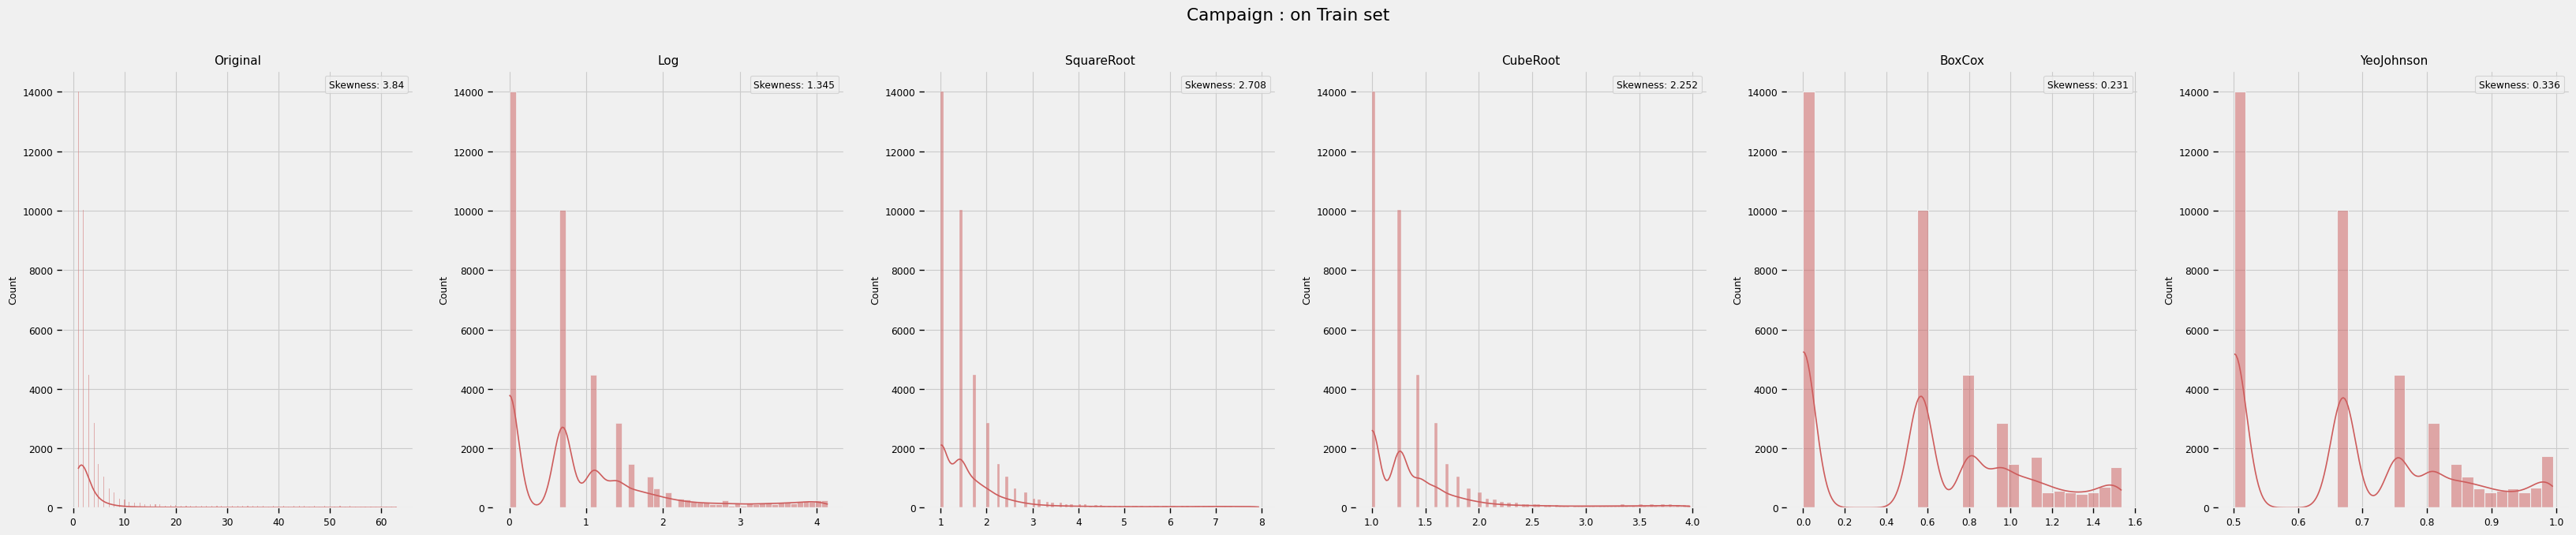

In [33]:
plot_transformed_features(actual_trainDF, 'campaign')

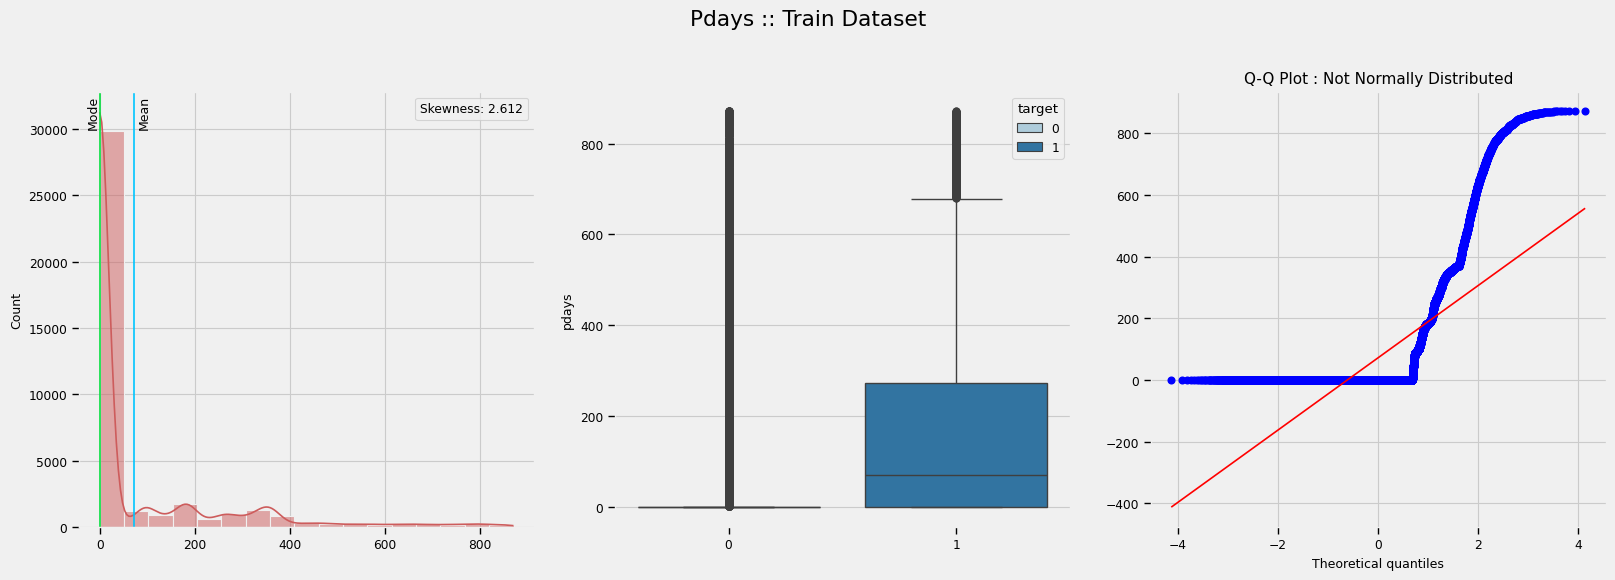

In [34]:
plot_continuous_param(actual_trainDF, 'pdays', kde_alone = False, mean_mode = True, box_not_violin = True)

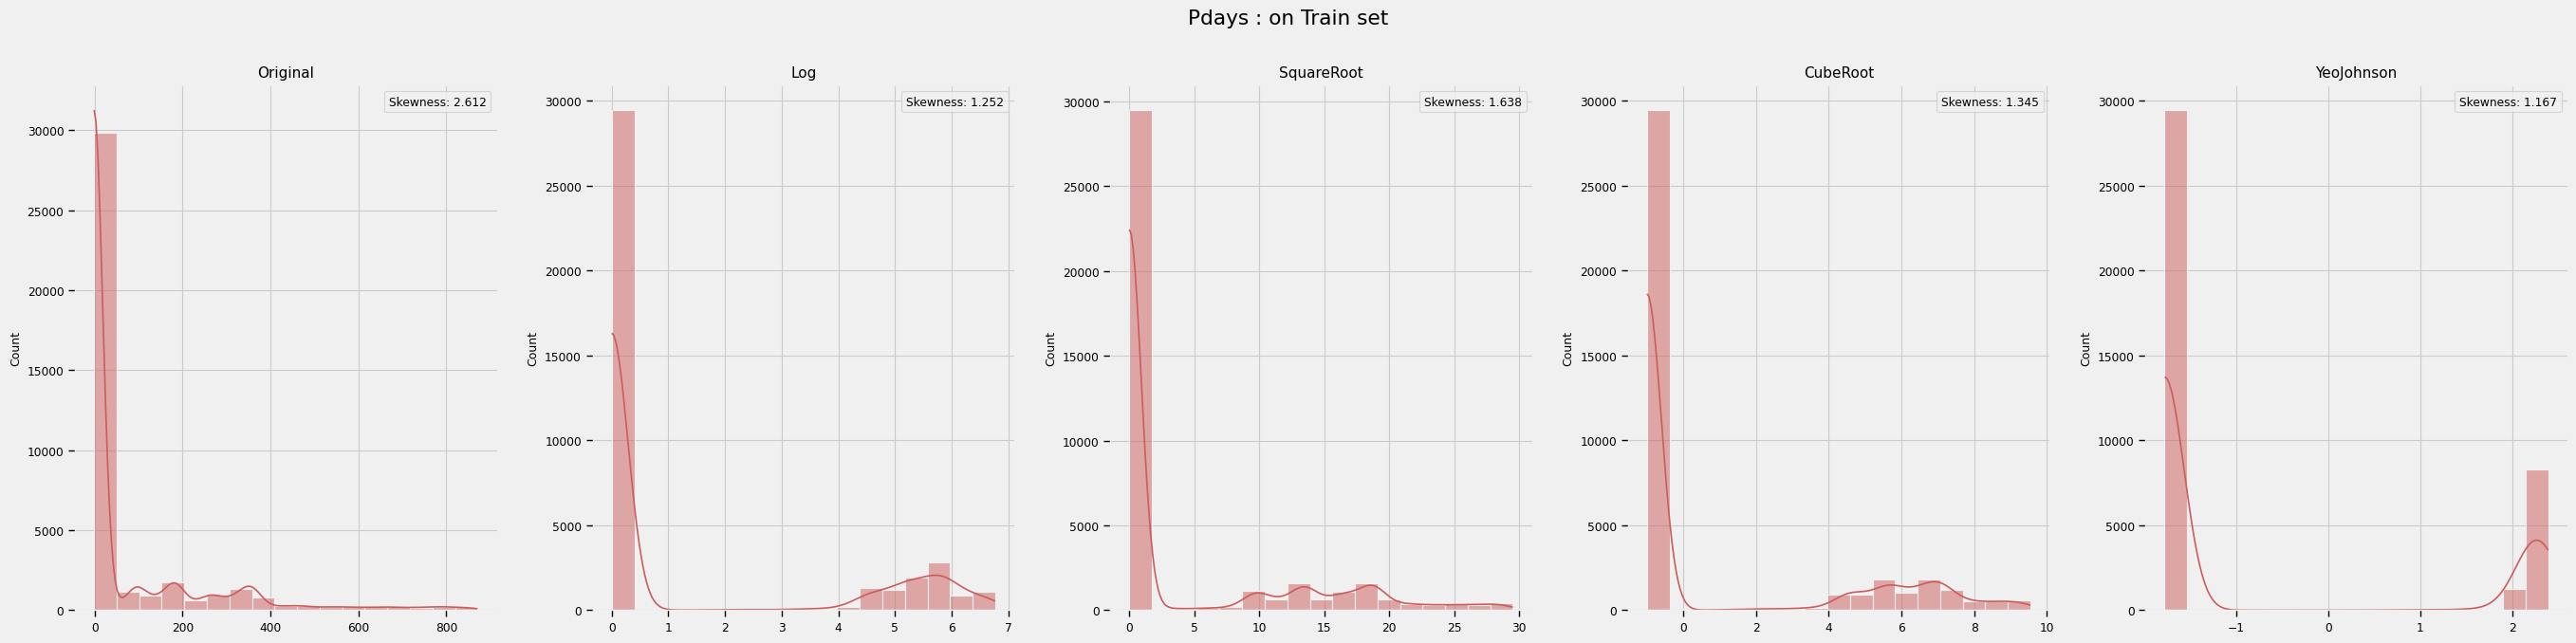

In [35]:
plot_transformed_features(actual_trainDF, 'pdays')

- Most of the values are 999, which means that the most of the customers have never been contacted before.

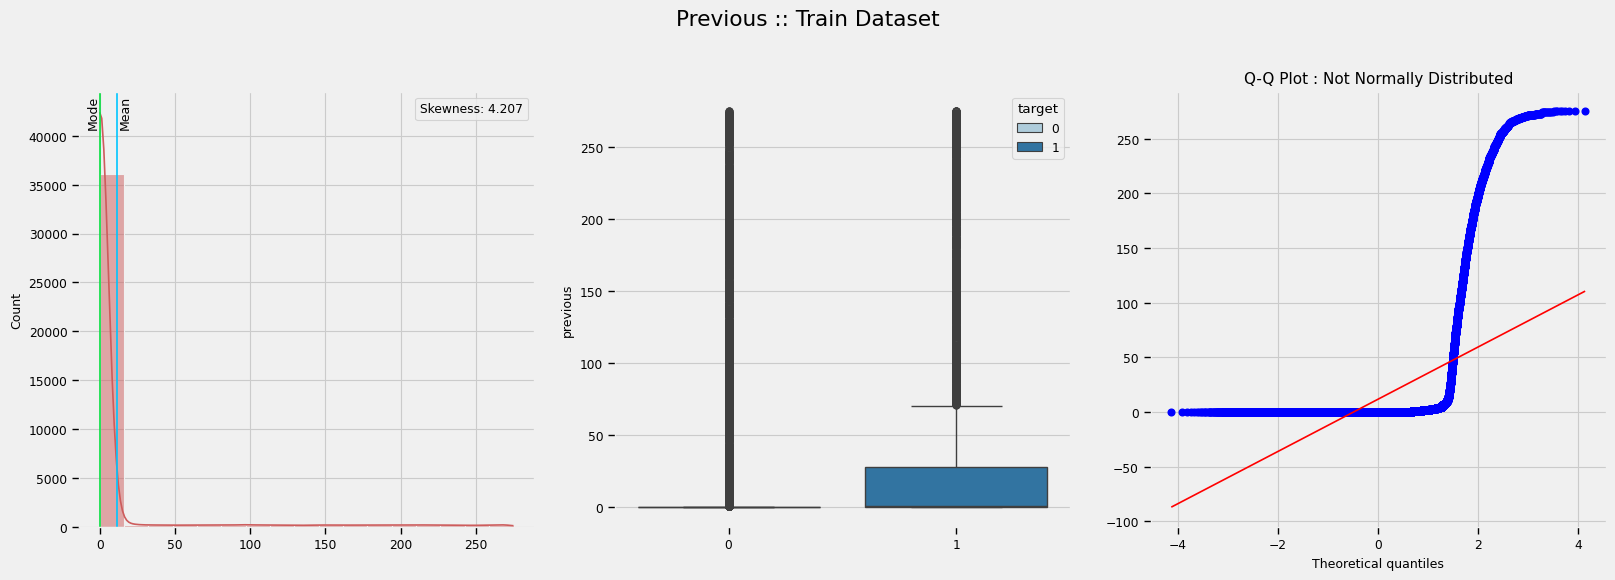

In [36]:
plot_continuous_param(actual_trainDF, 'previous', kde_alone = False, mean_mode = True, box_not_violin = True)

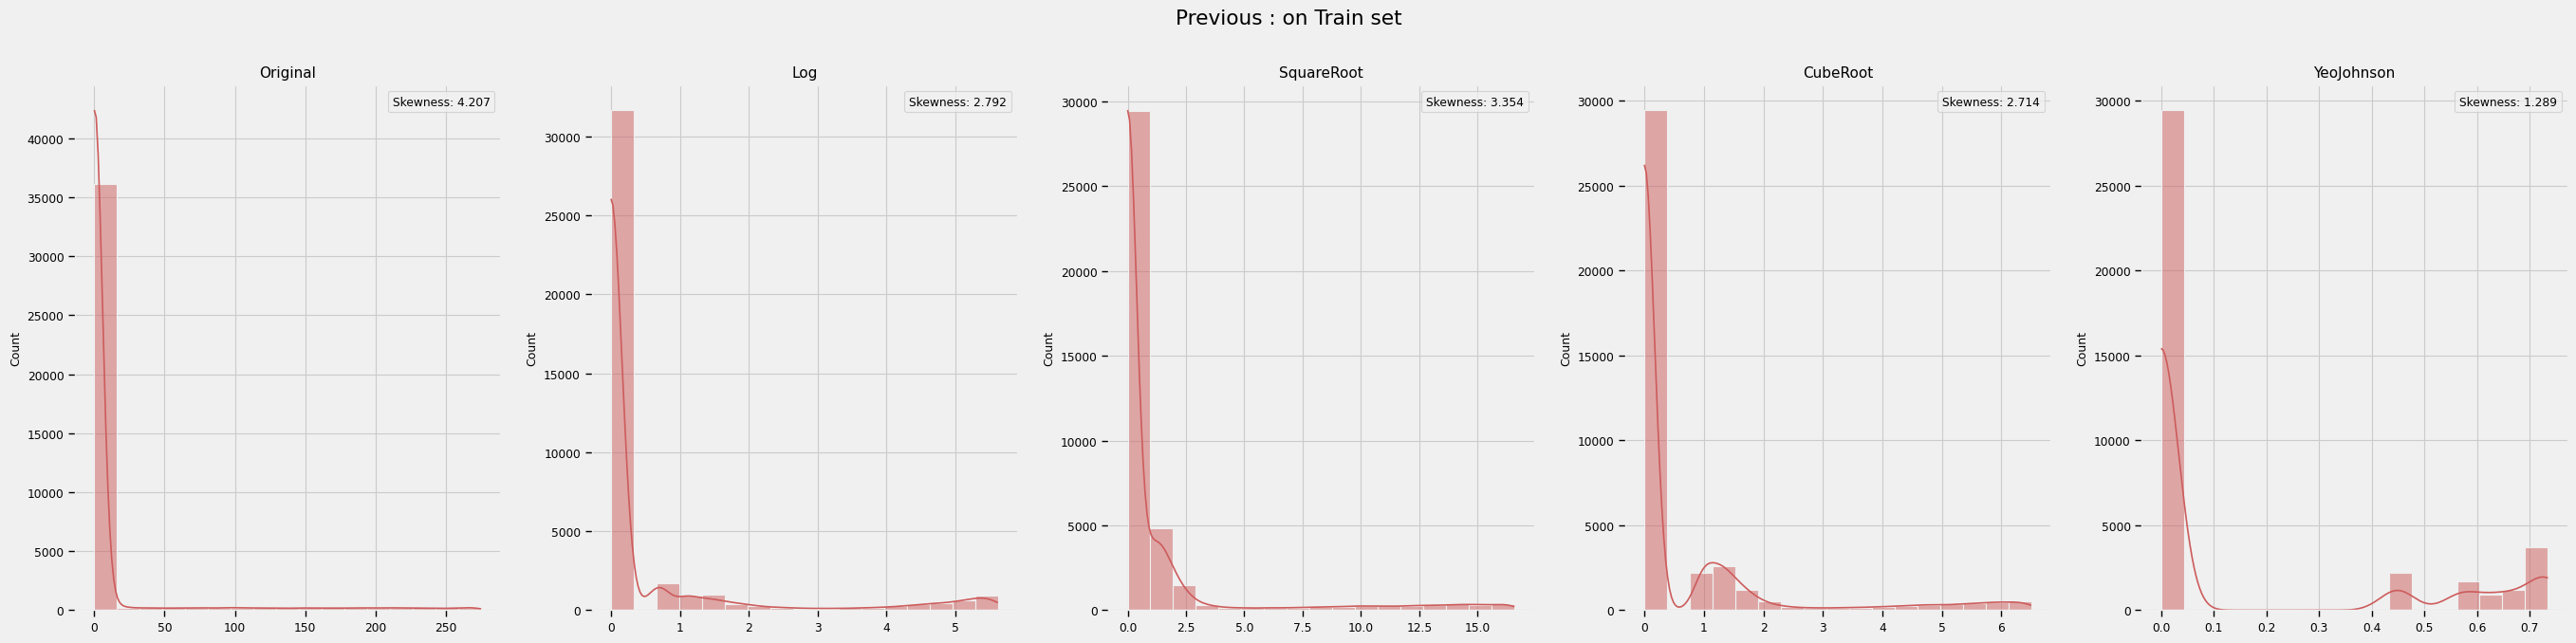

In [37]:
plot_transformed_features(actual_trainDF, 'previous')

## Correlation Heat Map

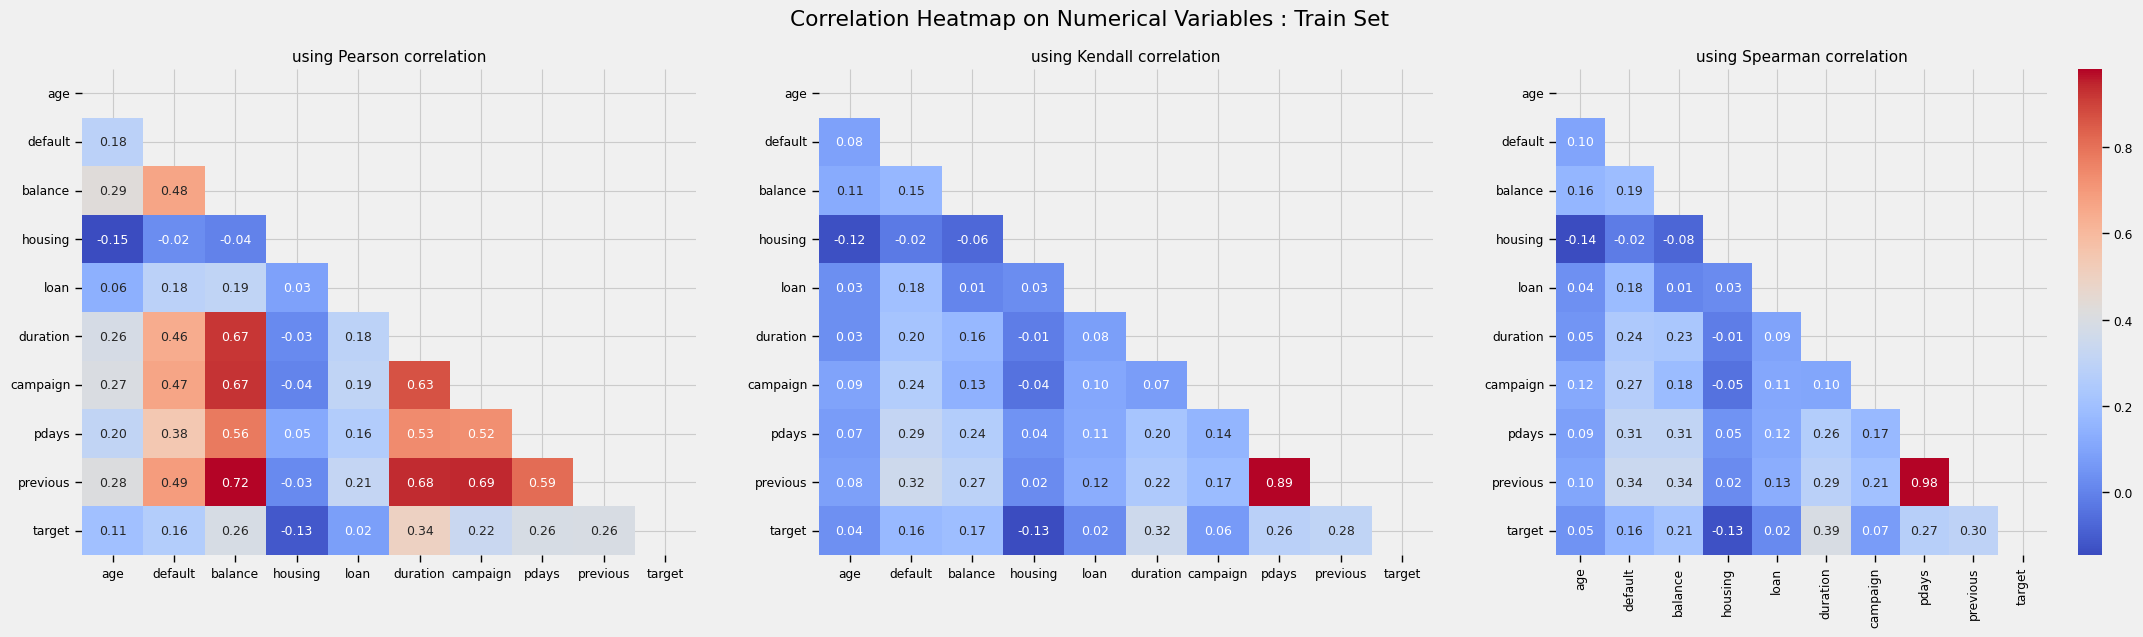

In [38]:
def plt_correlation_plot(df: pd.DataFrame) -> None:
    '''
    Plots correlation heatmaps using Pearson, Kendall, and Spearman methods for numerical variables.
    '''
    set_ = 'Train' if 'target' in df.columns else 'Test'
    
    fig = plt.figure(figsize = (3 * 8, 6))
    gs = GridSpec(1, 3)
    for idx, corr_ in enumerate(['pearson', 'kendall', 'spearman']):
        ax = plt.subplot(gs[0, idx])
        corr = df.select_dtypes(include = 'number').corr(method = corr_)
        mask = np.triu(np.ones_like(corr, dtype = bool))
        cbar_ = True if idx == 2 else False
        sns.heatmap(corr, annot = True, fmt = '.2f', annot_kws = {'size': 9}, cmap = 'coolwarm', mask = mask,
                    cbar = cbar_, ax = ax)
        ax.set_title(f'using {corr_.title()} correlation')
    fig.suptitle(f'Correlation Heatmap on Numerical Variables : {set_} Set')
    plt.show()

plt_correlation_plot(actual_trainDF)

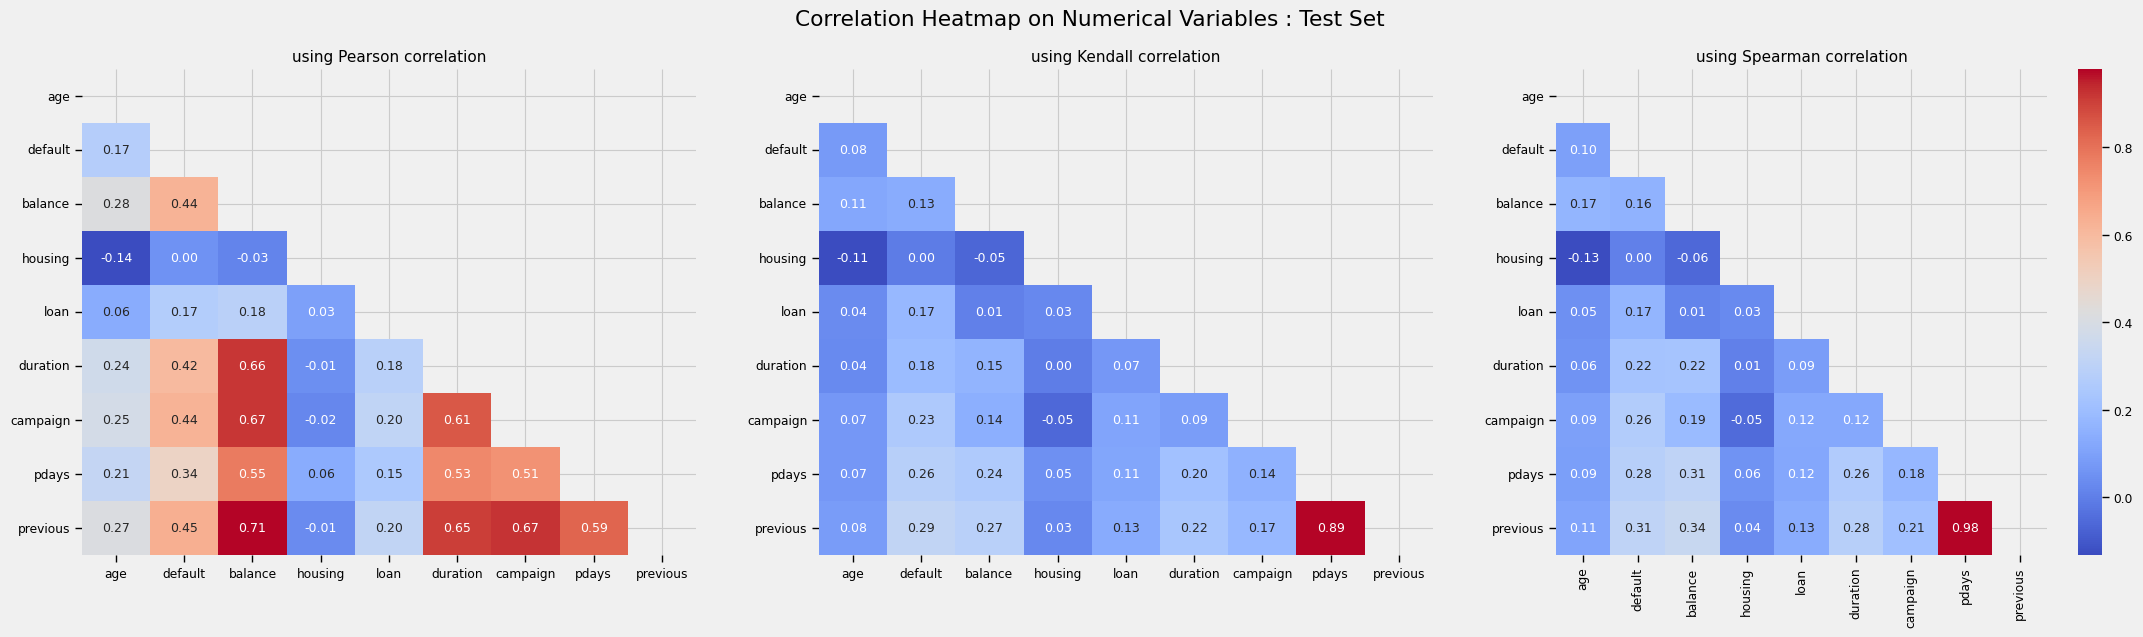

In [39]:
plt_correlation_plot(actual_testDF)

# Missing Value Analysis

In [40]:
def pie_plot_on_nan_cols(df: pd.DataFrame, feature: str) -> None:
    '''
    Plots pie charts to visualize the distribution of NaN values in a feature.
    '''
    count = df[feature].nunique(dropna = False)
    temp = pd.crosstab(df.fillna('NaN')[feature], df.fillna('NaN')['target']).reset_index(drop = False).copy(deep = True)

    if count > 4:
        fig = plt.figure(figsize = (count//4 * 3 , 3 * count//4))
        gs = GridSpec(count//4, 4)
    else:
        fig = plt.figure(figsize = (count * 3, 3))
        gs = GridSpec(1, count)

    for idx, row in enumerate(temp.values):
        ax = plt.subplot(gs[idx // 4, idx % 4])
        plt.pie(x = row[1:], labels = temp.columns[-2:], autopct = '%.2f%%', textprops={'fontsize': 8})
        ax.set_title(row[0])
    
    fig.suptitle(feature)
    plt.tight_layout(pad = 1)
    plt.show()

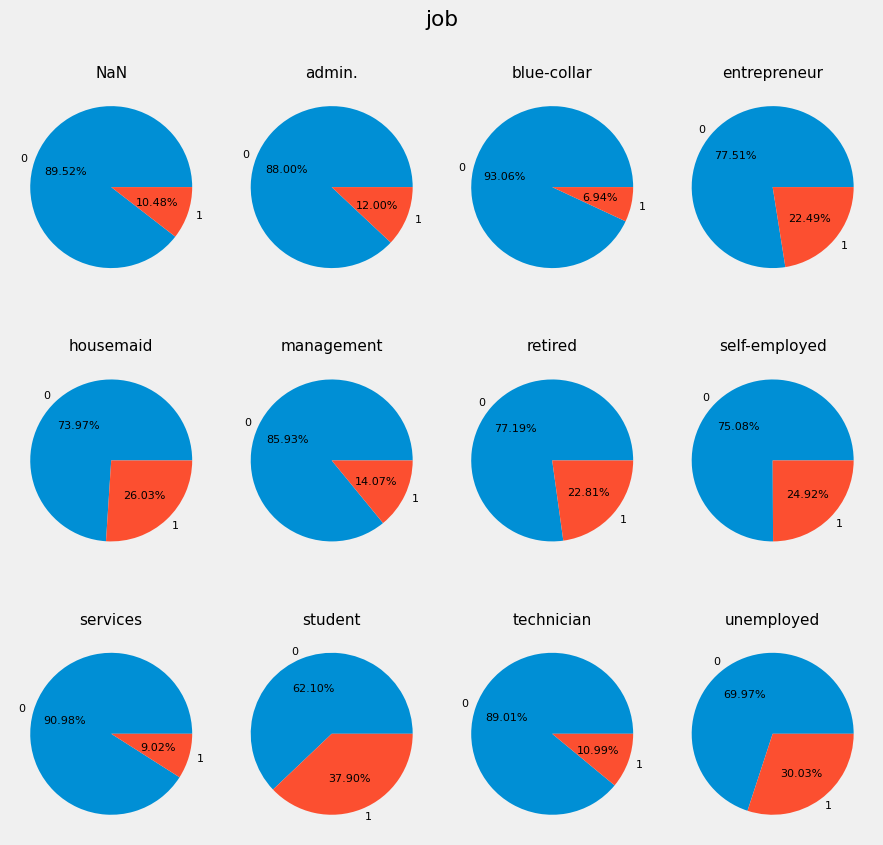

In [41]:
pie_plot_on_nan_cols(actual_trainDF, 'job')

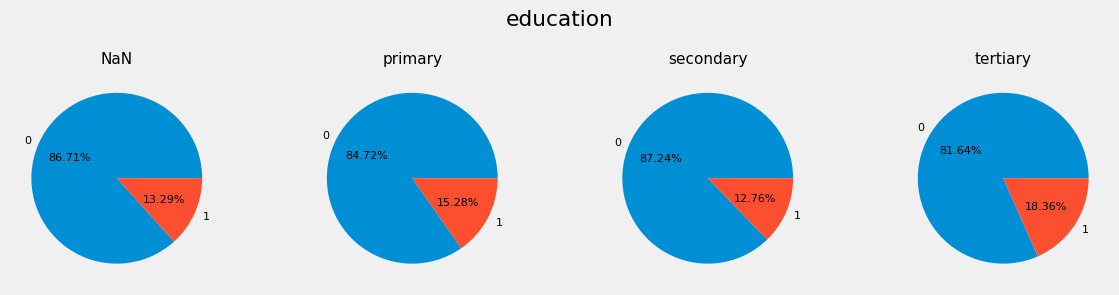

In [42]:
pie_plot_on_nan_cols(actual_trainDF, 'education')

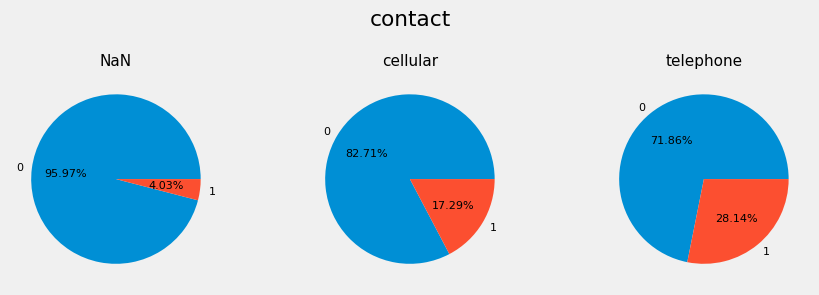

In [43]:
pie_plot_on_nan_cols(actual_trainDF, 'contact')

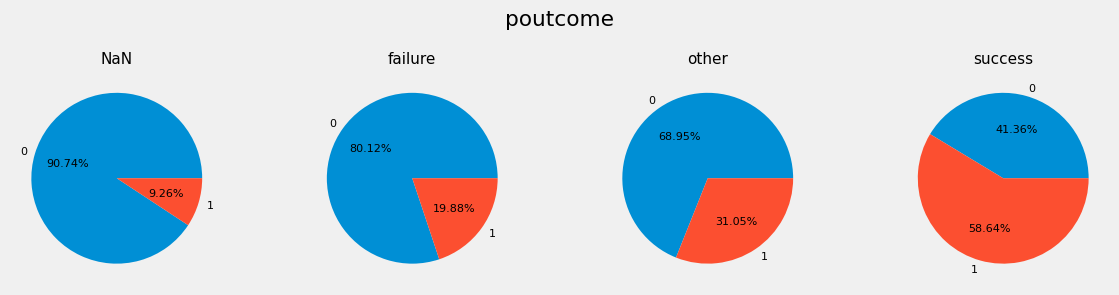

In [44]:
pie_plot_on_nan_cols(actual_trainDF, 'poutcome')

- From previous analysis we found that morethan 75% of the **poutcome** values are missing. Thus we will be removing this feature from further analysis.
- For the rest parameters will go for *mode* / *most frequest* imputaion methods.
- Also inorder to capture this missing value information, we will create new binary feature where `1` indicates *value is missing* and `0` indicating *value is present* on the primary dataset.

# Feature Engineering

In [45]:
map_quantiles_bins = {
                    # balance
                    '(-8019.001, 98.0]' : 'Q1',
                    '(98.0, 549.0]' : 'Q2',
                    '(549.0, 2030.0]' : 'Q3',
                    '(2030.0, 102127.0]' :'Q4',
                    # duration
                    '(-0.001, 109.0]' : 'Q1',
                    '(109.0, 197.0]' : 'Q2',
                    '(197.0, 380.0]' : 'Q3',
                    '(380.0, 4918.0]' : 'Q4'
                      }

age_bins = [0, 13, 18, 26, 36, 51, 61, 71, 81, 91, float('inf')]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Mid-Age Adult', 'Senior', 'Senior Plus',
              'Elder', 'Very Elder', 'Very Elder+']

In [46]:
# Creating new features from existing onces

actual_trainDF['day'] = actual_trainDF['last contact date'].dt.day
actual_trainDF['month'] = actual_trainDF['last contact date'].dt.month_name().astype('category')
actual_trainDF['day_of_week'] = actual_trainDF['last contact date'].dt.day_name().astype('category')
actual_trainDF['contact_date_scale'] = actual_trainDF['last contact date'].sub(actual_trainDF['last contact date'].min())
actual_trainDF['contact_date_scale'] = actual_trainDF['contact_date_scale'].div(np.timedelta64(1,'D'))

actual_testDF['day'] = actual_testDF['last contact date'].dt.day
actual_testDF['month'] = actual_testDF['last contact date'].dt.month_name().astype('category')
actual_testDF['day_of_week'] = actual_testDF['last contact date'].dt.day_name().astype('category')
actual_testDF['contact_date_scale'] = actual_testDF['last contact date'].sub(actual_testDF['last contact date'].min())
actual_testDF['contact_date_scale'] = actual_testDF['contact_date_scale'].div(np.timedelta64(1,'D'))

actual_trainDF['balanceBIN'] = pd.qcut(actual_trainDF.balance, q = 4)
actual_testDF['balanceBIN'] = pd.cut(actual_testDF['balance'], bins = actual_trainDF['balanceBIN'].cat.categories)

actual_trainDF['durationBIN'] = pd.qcut(actual_trainDF.duration, q = 4)
actual_testDF['durationBIN'] = pd.cut(actual_testDF['duration'], bins = actual_trainDF['durationBIN'].cat.categories)

actual_trainDF['ageBIN'] = pd.cut(actual_trainDF.age, bins = age_bins, labels = age_labels, right = False)
actual_testDF['ageBIN'] = pd.cut(actual_testDF.age, bins = age_bins, labels = age_labels, right = False)

actual_trainDF.balanceBIN = actual_trainDF.balanceBIN.astype(str).replace(map_quantiles_bins).astype('category')
actual_testDF.balanceBIN = actual_testDF.balanceBIN.astype(str).replace(map_quantiles_bins).astype('category')

actual_trainDF.durationBIN = actual_trainDF.durationBIN.astype(str).replace(map_quantiles_bins).astype('category')
actual_testDF.durationBIN = actual_testDF.durationBIN.astype(str).replace(map_quantiles_bins).astype('category')

In [47]:
# Removing not so important features

drop_col = ['poutcome', 'last contact date']

try:
    actual_trainDF.drop(drop_col, axis = 1, inplace = True)
    actual_testDF.drop(drop_col, axis = 1, inplace = True)
except:
    pass

## Fillign Missing Values using most_frequent strategy

In [48]:
# Converting object columns to categorical

for col in ['job', 'marital', 'education', 'contact']:
    actual_trainDF[col] = actual_trainDF[col].astype('category')
    actual_testDF[col] = actual_testDF[col].astype('category')

In [49]:
# Copying dataframe to new variable

trainDF_most_freq = actual_trainDF.copy(deep = True)
testDF_most_freq = actual_testDF.copy(deep = True)

In [50]:
print('Total mssing values in train set : ', sum(trainDF_most_freq.isnull().sum()))
print('Total mssing values in test set  : ', sum(testDF_most_freq.isnull().sum()))

Total mssing values in train set :  12032
Total mssing values in test set  :  3133


In [51]:
# Filling missing Values using most_frequent strategy and creating a new new column as binary

for col in ['job', 'education', 'contact']:

    # Creating new binary feature
    trainDF_most_freq[col + '_missing'] = np.where(trainDF_most_freq[col].isnull(), 1, 0)
    testDF_most_freq[col + '_missing'] = np.where(testDF_most_freq[col].isnull(), 1, 0)

    # Filling missing values with mode value
    mode_ = trainDF_most_freq[col].mode()[0]
    trainDF_most_freq[col] = trainDF_most_freq[col].fillna(mode_)
    testDF_most_freq[col] = testDF_most_freq[col].fillna(mode_)
    
print('Total mssing values in train set : ', sum(trainDF_most_freq.isnull().sum()))
print('Total mssing values in test set  : ', sum(testDF_most_freq.isnull().sum()))

Total mssing values in train set :  0
Total mssing values in test set  :  0


In [52]:
trainDF_most_freq.select_dtypes(include = 'category').head()

,job,marital,education,contact,month,day_of_week,balanceBIN,durationBIN,ageBIN
0,blue-collar,married,secondary,cellular,April,Friday,Q3,Q3,Adult
1,technician,married,secondary,telephone,October,Sunday,Q3,Q2,Senior
2,blue-collar,married,secondary,cellular,November,Saturday,Q3,Q3,Mid-Age Adult
3,admin.,married,secondary,telephone,September,Tuesday,Q2,Q1,Adult
4,entrepreneur,single,tertiary,cellular,January,Tuesday,Q2,Q4,Adult


In [53]:
testDF_most_freq.select_dtypes(include = 'category').head()

,job,marital,education,contact,month,day_of_week,balanceBIN,durationBIN,ageBIN
0,management,single,tertiary,cellular,November,Saturday,Q1,Q1,Mid-Age Adult
1,unemployed,married,tertiary,cellular,February,Thursday,Q3,Q1,Adult
2,blue-collar,single,secondary,cellular,July,Wednesday,Q1,Q1,Adult
3,admin.,married,primary,cellular,June,Wednesday,Q3,Q3,Mid-Age Adult
4,management,married,tertiary,cellular,March,Sunday,Q2,Q4,Senior


# Train Test Spliting

In [54]:
# Splitting data as, 20% test set and 80% as train set.

TEST_SIZE = 0.2

trainDF_most_Y = trainDF_most_freq.target
trainDF_most_X = trainDF_most_freq.drop(['target'], axis = 1)

In [55]:
# Like previously mentioned on observation, using stratified splitting

X_train, X_test, y_train, y_test = train_test_split(trainDF_most_X, trainDF_most_Y,
                                                    test_size = TEST_SIZE, stratify = trainDF_most_Y,
                                                    random_state = 48)

# Encoding and Scaling Features

In [56]:
num_fearures_ = ['age', 'campaign', 'pdays', 'previous', 'day', 'contact_date_scale', 'balance', 'duration']
ohe_fearures_ = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'balanceBIN', 'durationBIN', 'ageBIN']

In [57]:
def get_column_transformed_data(trainX: pd.DataFrame, trainY: pd.DataFrame,
                                testX: pd.Series, og_test_set: pd.DataFrame,
                                features_num: list, features_ohe: list,
                                num_feature_scaler: Normalizer,
                                on_full_train: bool = False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Transforms the numerical and categorical columns in train and test datasets using scaling and one-hot encoding.
    '''
    tansformed_test_X, tansformed_og_test_X = None, None
    
    colTrasns = ColumnTransformer(transformers = [
                                                 ('robustScalar', num_feature_scaler, features_num),
                                                 ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'),
                                                  features_ohe),
                                                 ],
                                 remainder = 'passthrough')
    
    tansformed_train_X = colTrasns.fit_transform(trainX, trainY)
    tansformed_train_X = pd.DataFrame(tansformed_train_X, columns = colTrasns.get_feature_names_out())
    print(f"Shape of Train X set post scaling and OHE {'':7}: {tansformed_train_X.shape}")
    
    if not on_full_train:
        tansformed_test_X = colTrasns.transform(testX)
        tansformed_test_X = pd.DataFrame(tansformed_test_X, columns = colTrasns.get_feature_names_out())
        print(f"Shape of Test X set post scaling and OHE {'':7} : {tansformed_test_X.shape}\n")
    else:
        tansformed_og_test_X = colTrasns.transform(og_test_set)
        tansformed_og_test_X = pd.DataFrame(tansformed_og_test_X, columns = colTrasns.get_feature_names_out())
        print(f"Shape of Original Test set post scaling and OHE {'':1}: {tansformed_og_test_X.shape}")
        
    return tansformed_train_X, tansformed_og_test_X, tansformed_test_X

In [58]:
# Here we are using Normalizer() for scaling numerical values.
# Instead we can also try, StandardScaler, MaxAbsScaler, MinMaxScaler and RobustScaler.

tansformed_train_X, _, tansformed_test_X = get_column_transformed_data(trainX = X_train,
                                                                       trainY = y_train,
                                                                       testX = X_test,
                                                                       og_test_set = testDF_most_freq,
                                                                       features_num = num_fearures_,
                                                                       features_ohe = ohe_fearures_,
                                                                       num_feature_scaler = Normalizer(),
                                                                       on_full_train = False)

og_tansformed_train_X, og_tansformed_test_X, _ = get_column_transformed_data(trainX = trainDF_most_X,
                                                                             trainY = trainDF_most_Y,
                                                                             testX = X_test,
                                                                             og_test_set = testDF_most_freq,
                                                                             features_num = num_fearures_,
                                                                             features_ohe = ohe_fearures_,
                                                                             num_feature_scaler = Normalizer(),
                                                                             on_full_train = True)

Shape of Train X set post scaling and OHE        : (31368, 59)
Shape of Test X set post scaling and OHE         : (7843, 59)

Shape of Train X set post scaling and OHE        : (39211, 59)
Shape of Original Test set post scaling and OHE  : (10000, 59)


# Model Training and Performance testing helper functions

In [59]:
def apply_SMOTE(trainX: pd.DataFrame, trainY: pd.Series, smoteObj: SMOTEENN) -> SMOTEENN:
    '''
    Applies the SMOTE technique to balance the classes in the dataset.
    '''
    return smoteObj.fit_resample(trainX, trainY)

In [60]:
def model_performance_calc(testY: pd.Series, pred_testY: pd.Series, trainY: pd.Series = None,
                           pred_trainY: pd.Series = '', text_: bool = None, round_: int = 5,
                           onTrain: bool = False, onTest: bool = True, plot_cm: bool = True) -> float:
    '''
    Calculates and prints the performance metrics (accuracy and F1-score) for a model and optionally plots
        the confusion matrix.
    '''
    if onTrain:
        accuracy = accuracy_score(y_true = trainY, y_pred = pred_trainY)
        f1Score = f1_score(y_true = trainY, y_pred = pred_trainY, average = 'macro')
        print(f"Accuracy Score on Train set {'':2}: {round( accuracy, round_)}")
        print(f"F1-Score on Train set {'':8}: {round( f1Score, round_)}")
        print('-' * 36)
        
    f1Score = f1_score(y_true = testY, y_pred = pred_testY, average = 'macro')
    
    if onTest:
        accuracy = accuracy_score(y_true = testY, y_pred = pred_testY)
        print(f"Accuracy Score on Test set {'':3}: {round( accuracy, round_)}")
        print(f"F1-Score on Test set {'':9}: {round( f1Score, round_)}\n")

    if plot_cm:
        # https://stackoverflow.com/a/69347137
        # https://stackoverflow.com/a/11250884
        plt.figure(figsize = (6, 5))
        ax = sns.heatmap(confusion_matrix(y_test, pred_testY), annot = True, fmt = 'd', cmap = 'Oranges',
                         annot_kws = {'size': 9}, cbar = False)
        plt.title(f'Confusion Matrix : {text_} on Test Set')
        ax.set_xticklabels(['no', 'yes'], rotation = 0)
        ax.set_yticklabels(['no', 'yes'], rotation = 0)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()
    
    return round(f1Score, 4)

In [61]:
def train_partial_classifier_model(classifier_: BaseEstimator, trainX_: pd.DataFrame, trainY_: pd.Series,
                                   testX_: pd.DataFrame, testY_: pd.Series, text_: str = '',
                                   plot_cm: bool = False, onTrain: bool = False,
                                   onTest: bool = True) -> tuple[BaseEstimator, float]:
    '''
    Trains a classifier on a portion of the data and calculates performance metrics.
    '''
    classifier_ = classifier_.fit(trainX_, trainY_)
    y_tr_pred = classifier_.predict(trainX_)
    y_te_pred = classifier_.predict(testX_)
    
    f1Score = model_performance_calc(testY_, y_te_pred, trainY_, y_tr_pred, text_ = text_, onTrain = onTrain,
                                     onTest = onTest, plot_cm = plot_cm)
    return classifier_, f1Score

In [62]:
def submission_classifier(classifier_: BaseEstimator, clf_name: str,
                          trainX_og: pd.DataFrame, trainY_og: pd.Series,
                          testX_: pd.DataFrame, submission_DF: pd.DataFrame = submissionDF,
                          train: bool = False, filename: str = 'submission') -> None:
    '''
    Prepares a submission file by training or using a pre-trained classifier.
    '''
    
    if train:
        print(f'Training {clf_name} on full Train Set for submission')
        classifier_ = classifier_.fit(trainX_og, trainY_og)
    else:
        print('Using previously Trained model for submission')

    submissionDF[clf_name] = classifier_.predict(testX_)
    submissionDF[clf_name] = submissionDF[clf_name].replace({0 : 'no', 1: 'yes'})
    submissionDF[['id', clf_name]].rename(columns = {clf_name : 'target'}).to_csv(f'../data/for_submission/{filename}.csv', index = False)
    submissionDF.to_csv('../data/for_submission/benchmark.csv', index = False)

# Dummy / BaseLine Classsifer Training

In [63]:
model_performance_df = pd.DataFrame(columns = ['ModelName', 'HyperParams', 'F1_Score_Macro'])

Accuracy Score on Train set   : 0.49946
F1-Score on Train set         : 0.42911
------------------------------------
Accuracy Score on Test set    : 0.50414
F1-Score on Test set          : 0.43441



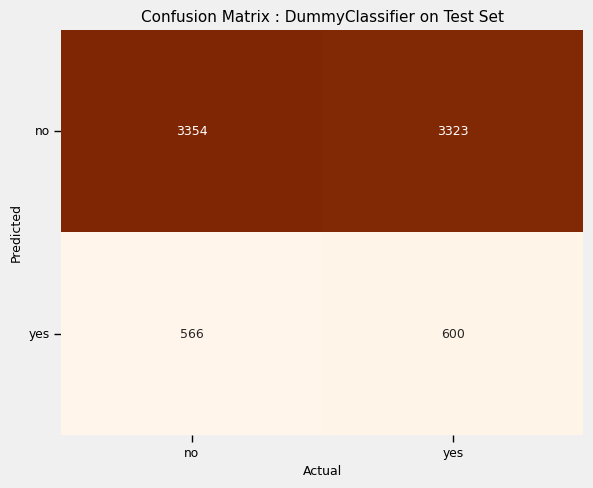

In [64]:
dummyClassifier_, dummy_f1Score = train_partial_classifier_model(DummyClassifier(strategy = 'uniform', random_state = 56),
                                                                 trainX_ = tansformed_train_X,
                                                                 trainY_ = y_train,
                                                                 testX_ = tansformed_test_X,
                                                                 testY_ = y_test,
                                                                 text_ = 'DummyClassifier',
                                                                 plot_cm = True,
                                                                 onTrain = True)

model_performance_df.loc[len(model_performance_df)] = ['DummyClassifier', {'strategy' : 'uniform'}, dummy_f1Score]

In [65]:
submission_classifier(classifier_ = dummyClassifier_, filename = 'submission',
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF,
                      train = False, clf_name = 'DummyClassifier')

Using previously Trained model for submission


# Linear Models without SMOTE

## LogisticRegression Classifier

Accuracy Score on Train set   : 0.86155
F1-Score on Train set         : 0.66388
------------------------------------
Accuracy Score on Test set    : 0.85439
F1-Score on Test set          : 0.6444



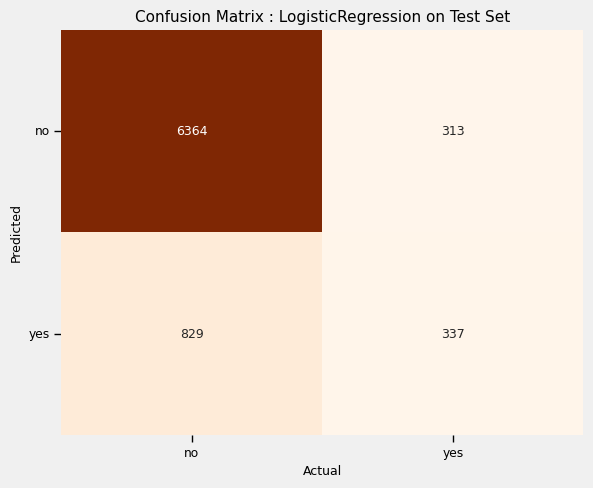

Using previously Trained model for submission


In [66]:
clf_name = 'LogisticRegression-Base'
logistClassifier_, logist_f1Score = train_partial_classifier_model(LogisticRegression(
                                                                    penalty = 'l2', tol = 0.0001, solver = 'lbfgs',
                                                                    max_iter = 100, n_jobs = -1,
                                                                    random_state = 45, verbose = 0),
                                                                   trainX_ = tansformed_train_X,
                                                                   trainY_ = y_train,
                                                                   testX_ = tansformed_test_X,
                                                                   testY_ = y_test,
                                                                   text_  = 'LogisticRegression',
                                                                   plot_cm = True,
                                                                   onTrain = True)
                                                             
model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       {'penalty' : 'l2', 'tol' : 0.0001,
                                                        'solver' : 'lbfgs', 'max_iter' : 100},
                                                       logist_f1Score]

submission_classifier(classifier_ = logistClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### LogisticRegression HyperParameter Tuning

In [67]:
# https://stackoverflow.com/a/71583205
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

grid_params = {'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
               'tol' : [1e-06, 1e-05, 0.0001, 0.001, 0.01],
               'max_iter' : [100, 150, 200, 300, 400, 500, 1000],
               'solver' : ['sag', 'liblinear', 'saga', 'lbfgs'],
               'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 0.8]}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'penalty' : [None],
               # 'tol' : [1e-06], # penalty=None will ignore the C and l1_ratio parameters
               'max_iter' : [100],
               'solver' : ['sag'],
               # 'C' : [0.0001], # penalty=None will ignore the C and l1_ratio parameters
              }

gridCV = GridSearchCV(LogisticRegression(n_jobs = -1, random_state = 45, verbose = 0), grid_params,
                      cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(tansformed_train_X, y_train)
gridCV.best_params_

/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'max_iter': 100, 'penalty': None, 'solver': 'sag'}

Accuracy Score on Train set   : 0.86362
F1-Score on Train set         : 0.67404
------------------------------------
Accuracy Score on Test set    : 0.85541
F1-Score on Test set          : 0.65221



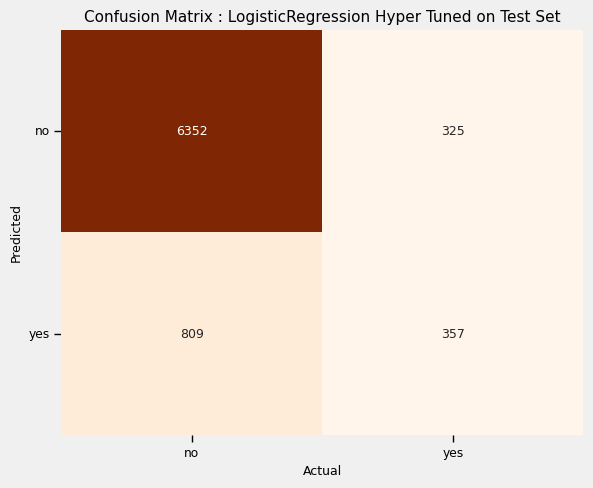

Using previously Trained model for submission


In [68]:
clf_name = 'LogisticRegression-Hyper-Base'
logistClassifier_, logist_f1Score = train_partial_classifier_model(LogisticRegression(
                                                                        **gridCV.best_params_, n_jobs = -1,
                                                                        random_state = 45, verbose = 0),
                                                                   trainX_ = tansformed_train_X,
                                                                   trainY_ = y_train,
                                                                   testX_ = tansformed_test_X,
                                                                   testY_ = y_test,
                                                                   text_  = 'LogisticRegression Hyper Tuned',
                                                                   plot_cm = True,
                                                                   onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name, gridCV.best_params_, logist_f1Score]

submission_classifier(classifier_ = logistClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### LogisticRegression HyperParameter Tuning on Full Train set

In [69]:
grid_params = {'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
               'tol' : [1e-06, 1e-05, 0.0001, 0.001, 0.01],
               'max_iter' : [100, 150, 200, 300, 400, 500, 1000],
               'solver' : ['sag', 'liblinear', 'saga', 'lbfgs'],
               'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 0.8],
              }

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'penalty' : [None],
               # 'tol' : [1e-06], # penalty=None will ignore the C and l1_ratio parameters
               'max_iter' : [300],
               'solver' : ['lbfgs'],
               # 'C' : [0.0001], # penalty=None will ignore the C and l1_ratio parameters
              }

gridCV = GridSearchCV(LogisticRegression(n_jobs = -1, random_state = 45, verbose = 0), grid_params,
                      cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(og_tansformed_train_X, trainDF_most_Y)
gridCV.best_params_

{'max_iter': 300, 'penalty': None, 'solver': 'lbfgs'}

In [70]:
clf_name = 'LogisticRegression-Hyper-Base-FullSet'
submission_classifier(classifier_ = LogisticRegression(**gridCV.best_params_, n_jobs = -1,
                                                       random_state = 45, verbose = 0),
                      filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = True)

Training LogisticRegression-Hyper-Base-FullSet on full Train Set for submission


## SVM (linear) Classifier

Accuracy Score on Train set   : 0.85785
F1-Score on Train set         : 0.67145
------------------------------------
Accuracy Score on Test set    : 0.85184
F1-Score on Test set          : 0.65364



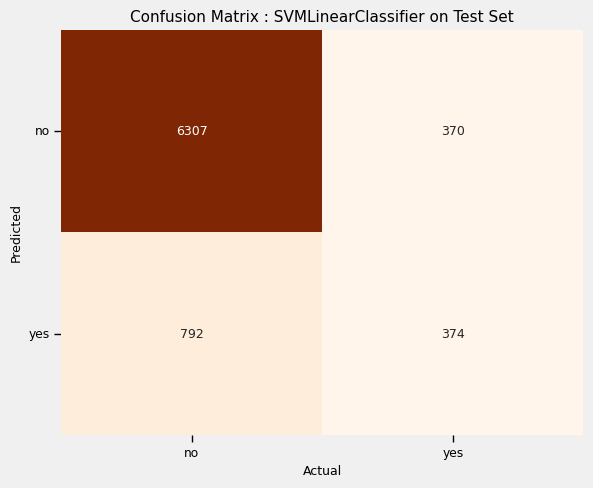

Using previously Trained model for submission


In [71]:
clf_name = 'SVMLinear-Base'
svmClassifier_, svm_f1Score = train_partial_classifier_model(SVC(
                                                                C = 1.0, kernel = 'linear',
                                                                max_iter  = -1 , random_state = 45),
                                                             trainX_ = tansformed_train_X,
                                                             trainY_ = y_train,
                                                             testX_ = tansformed_test_X,
                                                             testY_ = y_test,
                                                             text_  = 'SVMLinearClassifier',
                                                             plot_cm = True,
                                                             onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       {'C' : 1.0, 'kernel' : 'linear', 'max_iter' : -1},
                                                       svm_f1Score]

submission_classifier(classifier_ = svmClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

**Note**

Training SVM (linear) Classifier on Full Train set made no improvement in predictions, thus omiting the process.

# Non-Linear Models without SMOTE

## K-Neighbour Classifier

Accuracy Score on Train set   : 1.0
F1-Score on Train set         : 1.0
------------------------------------
Accuracy Score on Test set    : 0.84317
F1-Score on Test set          : 0.63137



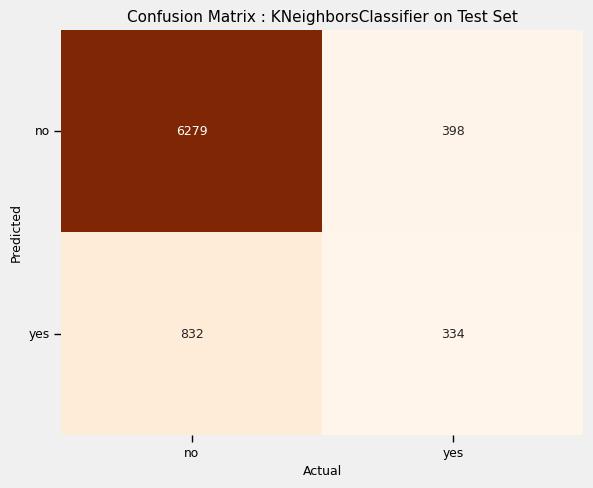

Using previously Trained model for submission


In [72]:
clf_name = 'KNeighborsClassifier-Base'
knnClassifier_, knn_f1Score = train_partial_classifier_model(KNeighborsClassifier(
                                                                n_neighbors = 5, weights = 'distance',
                                                                metric = 'minkowski', n_jobs = -1),
                                                             trainX_ = tansformed_train_X,
                                                             trainY_ = y_train,
                                                             testX_ = tansformed_test_X,
                                                             testY_ = y_test,
                                                             text_  = 'KNeighborsClassifier',
                                                             plot_cm = True,
                                                             onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       {'n_neighbors' : 5, 'weights' : 'distance',
                                                        'metric' : 'minkowski'},
                                                       knn_f1Score]

submission_classifier(classifier_ = knnClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### KNN HyperParameter Tuning

In [73]:
grid_params = {'algorithm': ['ball_tree', 'brute', 'kd_tree'],
               'metric': ['cosine', 'euclidean', 'manhattan'],
               'n_neighbors': [2, 3, 4, 5, 6],
               'weights': ['distance', 'uniform']}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'algorithm': ['ball_tree'],
               'metric': ['manhattan'],
               'n_neighbors': [3],
               'weights': ['uniform']}

gridCV = GridSearchCV(KNeighborsClassifier(n_jobs = -1), grid_params, cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(tansformed_train_X, y_train)
gridCV.best_params_

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'uniform'}

Accuracy Score on Train set   : 0.91236
F1-Score on Train set         : 0.80611
------------------------------------
Accuracy Score on Test set    : 0.83845
F1-Score on Test set          : 0.63304



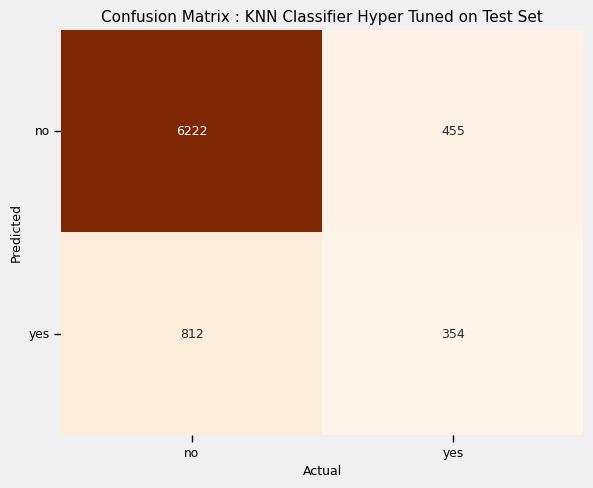

Using previously Trained model for submission


In [74]:
clf_name = 'KNeighborsClassifier-Hyper-Base'
knnClassifier_, knn_f1Score = train_partial_classifier_model(KNeighborsClassifier(**gridCV.best_params_,
                                                                                  n_jobs = -1),
                                                             trainX_ = tansformed_train_X,
                                                             trainY_ = y_train,
                                                             testX_ = tansformed_test_X,
                                                             testY_ = y_test,
                                                             text_  = 'KNN Classifier Hyper Tuned',
                                                             plot_cm = True,
                                                             onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       gridCV.best_params_,
                                                       knn_f1Score]

submission_classifier(classifier_ = knnClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### KNN HyperParameter Tuning on Full Train set

In [75]:
grid_params = {'algorithm': ['ball_tree', 'brute', 'kd_tree'],
               'metric': ['cosine', 'euclidean', 'manhattan'],
               'n_neighbors': [2, 3, 4, 5, 6],
               'weights': ['distance', 'uniform']}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'algorithm': ['ball_tree'],
               'metric': ['manhattan'],
               'n_neighbors': [4],
               'weights': ['distance']}

gridCV = GridSearchCV(KNeighborsClassifier(n_jobs = -1), grid_params, cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(og_tansformed_train_X, trainDF_most_Y)
gridCV.best_params_

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 4,
 'weights': 'distance'}

In [76]:
clf_name = 'KNeighborsClassifier-Hyper-Base-FullSet'
submission_classifier(classifier_ = KNeighborsClassifier(**gridCV.best_params_, n_jobs = -1),
                      filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = True)

Training KNeighborsClassifier-Hyper-Base-FullSet on full Train Set for submission


## DecisionTreeClassifier Classifier

Accuracy Score on Train set   : 1.0
F1-Score on Train set         : 1.0
------------------------------------
Accuracy Score on Test set    : 0.83182
F1-Score on Test set          : 0.67722



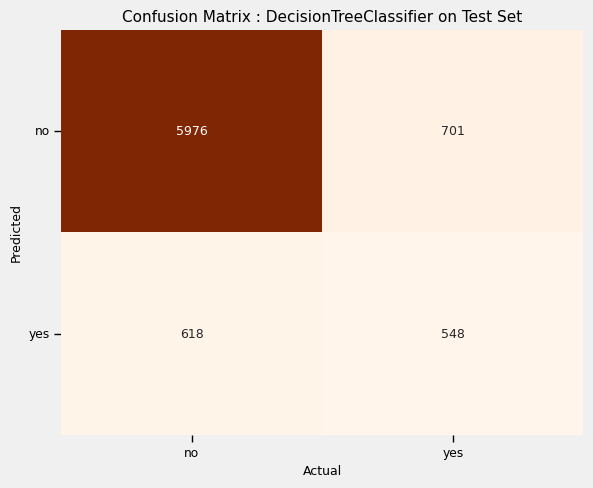

Using previously Trained model for submission


In [77]:
clf_name = 'DecisionTreeClassifier-Base'
dtClassifier_, dt_f1Score = train_partial_classifier_model(DecisionTreeClassifier(
                                                                criterion = 'gini', min_samples_split = 2,
                                                                min_samples_leaf = 1, max_depth = None,
                                                                random_state = 45),
                                                             trainX_ = tansformed_train_X,
                                                             trainY_ = y_train,
                                                             testX_ = tansformed_test_X,
                                                             testY_ = y_test,
                                                             text_  = 'DecisionTreeClassifier',
                                                             plot_cm = True,
                                                             onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       {'criterion' : 'gini', 'max_depth' : None,
                                                        'min_samples_split' : 2, 'min_samples_leaf' : 1},
                                                       dt_f1Score]

submission_classifier(classifier_ = dtClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### DecisionTreeClassifier HyperParameter Tuning

In [78]:
grid_params = {'criterion': ['entropy', 'gini', 'log_loss'],
               'splitter': ['best', 'random'],
               'max_depth': [None, 30, 40, 46, 48],
               'min_samples_split': [2, 3, 5, 8],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': [None, 'log2', 'sqrt']}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'criterion': ['gini'],
               'max_depth': [30],
               'max_features': [None],
               'min_samples_leaf': [1],
               'min_samples_split': [8],
               'splitter': ['random']}
    
gridCV = GridSearchCV(DecisionTreeClassifier(random_state = 45),
                      grid_params, cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(tansformed_train_X, y_train)
gridCV.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'splitter': 'random'}

Accuracy Score on Train set   : 0.95342
F1-Score on Train set         : 0.90334
------------------------------------
Accuracy Score on Test set    : 0.83692
F1-Score on Test set          : 0.66682



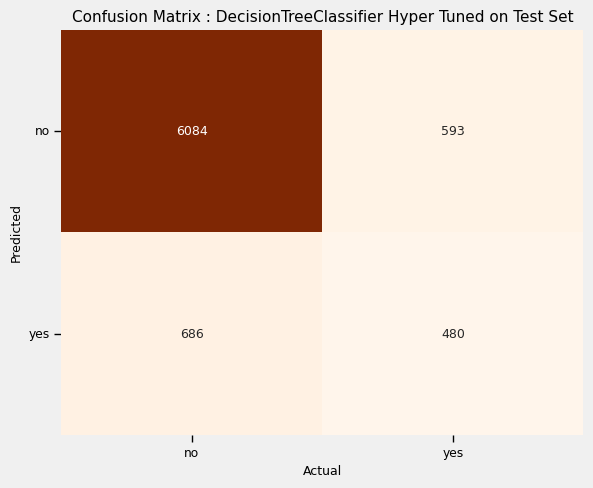

Using previously Trained model for submission


In [79]:
clf_name = 'DecisionTreeClassifier-Hyper-Base'
dtClassifier_, dt_f1Score = train_partial_classifier_model(DecisionTreeClassifier(
                                                                **gridCV.best_params_, random_state = 45),
                                                             trainX_ = tansformed_train_X,
                                                             trainY_ = y_train,
                                                             testX_ = tansformed_test_X,
                                                             testY_ = y_test,
                                                             text_  = 'DecisionTreeClassifier Hyper Tuned',
                                                             plot_cm = True,
                                                             onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name, gridCV.best_params_, dt_f1Score]

submission_classifier(classifier_ = dtClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### DecisionTreeClassifier HyperParameter Tuning on Full Train set

In [80]:
grid_params = {'criterion': ['entropy', 'gini', 'log_loss'],
               'splitter': ['best', 'random'],
               'max_depth': [None, 30, 40, 46, 48],
               'min_samples_split': [2, 3, 5, 8],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': [None, 'log2', 'sqrt']}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'criterion': ['entropy'],
               'max_depth': [40],
               'max_features': [None],
               'min_samples_leaf': [1],
               'min_samples_split': [8],
               'splitter': ['random']}

gridCV = GridSearchCV(DecisionTreeClassifier(random_state = 45),
                      grid_params, cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(og_tansformed_train_X, trainDF_most_Y)
gridCV.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'splitter': 'random'}

In [81]:
clf_name = 'DecisionTreeClassifier-Hyper-Base-FullSet'
submission_classifier(classifier_ = DecisionTreeClassifier(**gridCV.best_params_, random_state = 45),
                      filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = trainDF_most_Y,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = True)

Training DecisionTreeClassifier-Hyper-Base-FullSet on full Train Set for submission


# Applying SMOTE

In [82]:
smote_OBJ = SMOTEENN(random_state = 25, n_jobs = -1)

print(f'Shape of Train X, before SMOTE : {tansformed_train_X.shape}')
tansformed_train_X, y_train = apply_SMOTE(trainX = tansformed_train_X, trainY = y_train,
                                          smoteObj = smote_OBJ)
print(f'Shape of Train X, after SMOTE  : {tansformed_train_X.shape}\n')

print(f'Shape of actual Train X, before SMOTE : {og_tansformed_train_X.shape}')
og_tansformed_train_X, og_y_train = apply_SMOTE(trainX = og_tansformed_train_X, trainY = trainDF_most_Y,
                                          smoteObj = smote_OBJ)
print(f'Shape of actual Train X, after SMOTE  : {og_tansformed_train_X.shape}')

Shape of Train X, before SMOTE : (31368, 59)
Shape of Train X, after SMOTE  : (44608, 59)

Shape of actual Train X, before SMOTE : (39211, 59)
Shape of actual Train X, after SMOTE  : (55549, 59)


# Linear Models with SMOTE

## LogisticRegression Classifier

Accuracy Score on Train set   : 0.92055
F1-Score on Train set         : 0.91864
------------------------------------
Accuracy Score on Test set    : 0.76042
F1-Score on Test set          : 0.68342



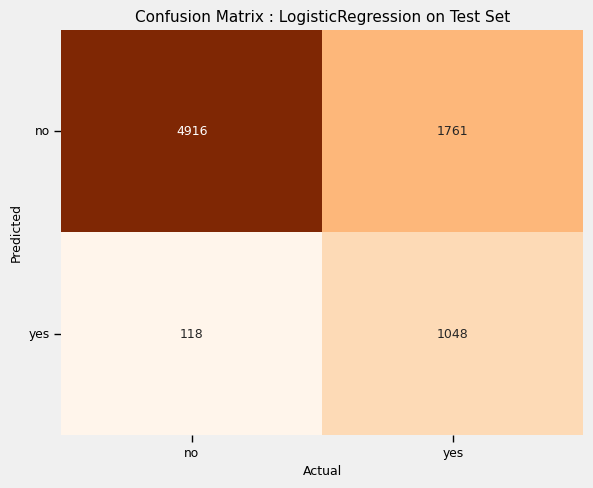

Using previously Trained model for submission


In [83]:
clf_name = 'LogisticRegression-SMOTE'
logistClassifier_, logist_f1Score = train_partial_classifier_model(LogisticRegression(
                                                                    penalty = 'l2', tol = 0.0001, solver = 'lbfgs',
                                                                    max_iter = 100, n_jobs = -1,
                                                                    random_state = 45, verbose = 0),
                                                                   trainX_ = tansformed_train_X,
                                                                   trainY_ = y_train,
                                                                   testX_ = tansformed_test_X,
                                                                   testY_ = y_test,
                                                                   text_  = 'LogisticRegression',
                                                                   plot_cm = True,
                                                                   onTrain = True)
                                                             
model_performance_df.loc[len(model_performance_df)] = [clf_name,
                                                       {'penalty' : 'l2', 'tol' : 0.0001,
                                                        'solver' : 'lbfgs', 'max_iter' : 100},
                                                       logist_f1Score]

submission_classifier(classifier_ = logistClassifier_, filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = og_y_train,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = False)

### LogisticRegression HyperParameter Tuning

In [84]:
grid_params = {'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
               'tol' : [1e-06, 1e-05, 0.0001, 0.001, 0.01],
               'max_iter' : [100, 150, 200, 300, 400, 500, 1000],
               'solver' : ['sag', 'liblinear', 'saga', 'lbfgs'],
               'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 0.8]}

# Best parameters received post hyper-parameter tuning with cross-validation 5
grid_params = {'penalty': [None],
               'tol': [1e-06],
               'C': [0.0001],
               'solver': ['lbfgs'],
               'max_iter': [400]}

gridCV = GridSearchCV(LogisticRegression(n_jobs = -1, random_state = 45, verbose = 0), grid_params,
                      cv = 2, scoring = 'f1_macro', n_jobs = -1)

gridCV.fit(tansformed_train_X, y_train)
gridCV.best_params_

/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/lin

{'C': 0.0001,
 'max_iter': 400,
 'penalty': None,
 'solver': 'lbfgs',
 'tol': 1e-06}

/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score on Train set   : 0.92277
F1-Score on Train set         : 0.92085
------------------------------------
Accuracy Score on Test set    : 0.76093
F1-Score on Test set          : 0.68441



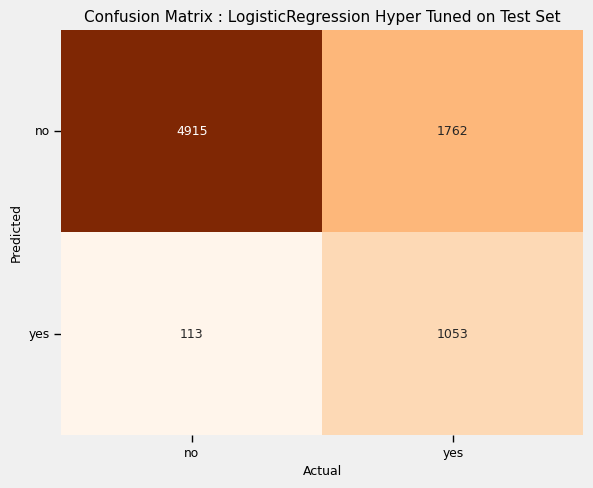

Training LogisticRegression-Hyper-SMOTE-FullSet on full Train Set for submission


/home/jishnu/anaconda3/envs/mlppr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
clf_name = 'LogisticRegression-Hyper-SMOTE'
logistClassifier_, logist_f1Score = train_partial_classifier_model(LogisticRegression(
                                                                        **gridCV.best_params_, n_jobs = -1,
                                                                        random_state = 45, verbose = 0),
                                                                   trainX_ = tansformed_train_X,
                                                                   trainY_ = y_train,
                                                                   testX_ = tansformed_test_X,
                                                                   testY_ = y_test,
                                                                   text_  = 'LogisticRegression Hyper Tuned',
                                                                   plot_cm = True,
                                                                   onTrain = True)

model_performance_df.loc[len(model_performance_df)] = [clf_name, gridCV.best_params_, logist_f1Score]

clf_name = 'LogisticRegression-Hyper-SMOTE-FullSet'
submission_classifier(classifier_ = LogisticRegression(**gridCV.best_params_, n_jobs = -1,
                                                       random_state = 45, verbose = 0),
                      filename = 'submission', clf_name = clf_name,
                      trainX_og = og_tansformed_train_X, trainY_og = og_y_train,
                      testX_ = og_tansformed_test_X, submission_DF = submissionDF, train = True)

In [86]:
model_performance_df.style

,ModelName,HyperParams,F1_Score_Macro
0,DummyClassifier,{'strategy': 'uniform'},0.434400
1,LogisticRegression-Base,"{'penalty': 'l2', 'tol': 0.0001, 'solver': 'lbfgs', 'max_iter': 100}",0.644400
2,LogisticRegression-Hyper-Base,"{'max_iter': 100, 'penalty': None, 'solver': 'sag'}",0.652200
3,SVMLinear-Base,"{'C': 1.0, 'kernel': 'linear', 'max_iter': -1}",0.653600
4,KNeighborsClassifier-Base,"{'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski'}",0.631400
5,KNeighborsClassifier-Hyper-Base,"{'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}",0.633000
6,DecisionTreeClassifier-Base,"{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}",0.677200
7,DecisionTreeClassifier-Hyper-Base,"{'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'random'}",0.666800
8,LogisticRegression-SMOTE,"{'penalty': 'l2', 'tol': 0.0001, 'solver': 'lbfgs', 'max_iter': 100}",0.683400
9,LogisticRegression-Hyper-SMOTE,"{'C': 0.0001, 'max_iter': 400, 'penalty': None, 'solver': 'lbfgs', 'tol': 1e-06}",0.684400
